## Imports

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import *

WORLDX, WORLDY = 24, 24 

## Remote API Functions

In [191]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
pioneer = sim.getObject('/Pioneer_p3dx')
print("Printando o pioninho: " + str(pioneer))

Printando o pioninho: 15


## Gradiente

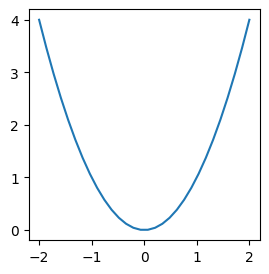

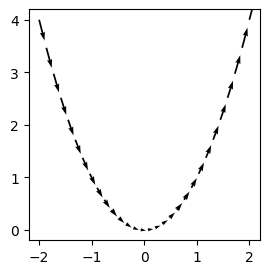

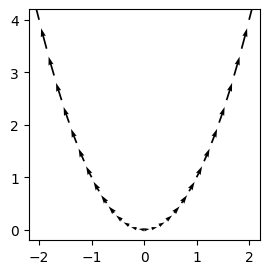

In [192]:
# Atenção com a ordem dos pontos
xn = np.linspace(0, -2, 15)
xp = np.linspace(0, 2, 15)
x =  np.linspace(-2, 2, 30)
y = x**2


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
plt.plot(x, y)


dx = np.gradient(x)
dy = np.gradient(y)

fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
ax.quiver(x, y, dx, dy)


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

y = xn**2
dx = np.gradient(xn)
dy = np.gradient(y)
ax.quiver(xn, y, dx, dy)

y = xp**2
dx = np.gradient(xp)
dy = np.gradient(y)
ax.quiver(xp, y, dx, dy)

#### Funções auxiliares para coleta de dados da API do CoppeliaSim

In [193]:
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

## Attraction force

Goal [1.175, 6.050000000000001, 0.0]


(0.0, 24.0)

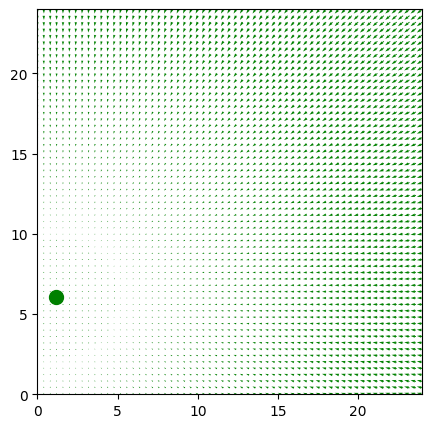

In [194]:
def att_force(q, goal, katt=.01):
    return katt*(np.array(goal) - np.array(q))

#goal = np.array([8, 2])
goal = get_object_position(sim, '/tree')
print("Goal", goal)

# reshape goal to 2 element array
goal = np.array(goal[:2])


fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

XX, YY = np.meshgrid(np.arange(0, WORLDX+.4, .4), np.arange(0, WORLDY+.4, .4))
XY = np.dstack([XX, YY]).reshape(-1, 2)

Fatt = att_force(XY, goal)
Fatt_x = Fatt[:,0] 
Fatt_y = Fatt[:,1]

ax.quiver(XX, YY, Fatt_x, Fatt_y, color='g')

plt.plot(goal[0], goal[1], 'og', markersize=10)
    
ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

## Repulsion force

ori ->  [0.0, 0.0, -1.5707963267950025]
Obstacle [ 4.75        4.55        0.          0.         -1.57079633]


(0.0, 24.0)

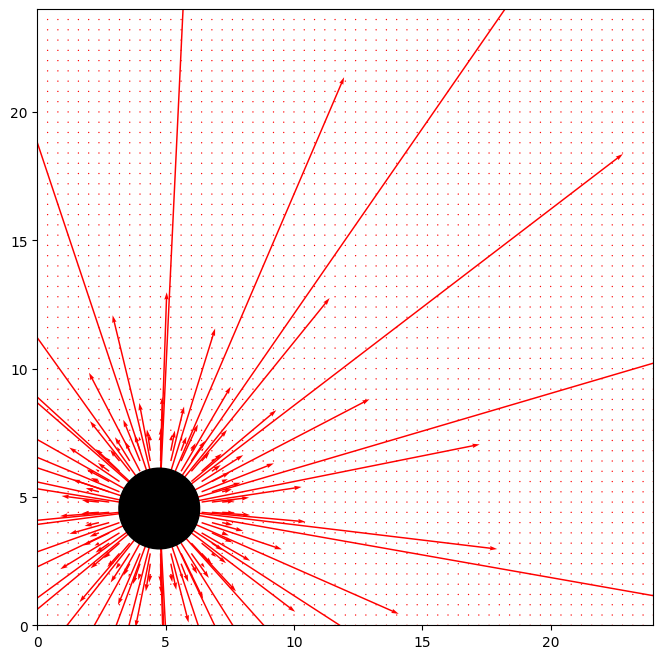

In [195]:
def rep_force(q, obs, R=3, krep=.1):
    
    # Obstáculo: (x, y, r)
    v = q - obs[0:2]
    d = np.linalg.norm(v, axis=1) - obs[2]
    d = d.reshape((len(v) ,1))
    
    # Adicionando uma pequena constante ao raio para evitar divisão por zero
    obs_radius = obs[2] if obs[2] > 0 else 0.001  
    rep = (1/d**2)*((1/d)-(1/R))*(v/d)    
    
    invalid = np.squeeze(d > R)
    rep[invalid, :] = 0
    
    return krep*rep

# Obstáculo: (x, y, r)
#obs = np.array([3, 4, .5])
obs = get_object_position(sim, '/Bump')
obs = np.array(obs[:2])
obs_ori = get_object_orientation(sim, '/Bump')
print("ori -> ", obs_ori)
# juntar os vetores obs e terceira_posicao
#obs = np.hstack((obs, obs_ori[2]))
obs = np.concatenate((obs, obs_ori))#[2:3] 
print("Obstacle", np.array(obs))

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

Frep = rep_force(XY,  np.array(obs))
Frep_x = np.copy(Frep[:,0])  # Cuidado com as referências
Frep_y = np.copy(Frep[:,1])  # Cuidado com as referências

# Threshold para visualização
fmax = .15
Fm = np.linalg.norm(Frep, axis=1)
Frep_x[Fm > fmax], Frep_y[Fm > fmax] = 0, 0

ax.quiver(XX, YY, Frep_x, Frep_y, color='r')
ax.add_patch(patches.Circle((obs[0], obs[1]), obs[4], color='k'))

ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

## Força Total

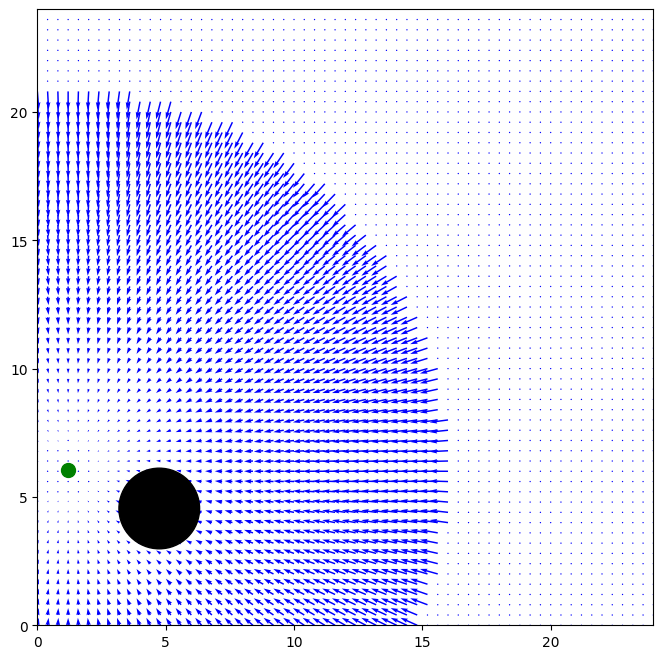

In [196]:
Ft = Fatt + Frep

# Normalização
# Ft = Ft / np.linalg.norm(Ft, axis=1).reshape((len(Ft), 1))

Ft_x = Ft[:,0]
Ft_y = Ft[:,1]

# Threshold para visualização
fmax = .15
Fm = np.linalg.norm(Ft, axis=1)
Ft_x[Fm > fmax], Ft_y[Fm > fmax] = 0, 0

# Plotando a força total
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
ax.quiver(XX, YY, Ft_x, Ft_y, color='b')

# Plotando o objetivo
plt.plot(goal[0], goal[1], 'og', markersize=10)

# Plotando o obstáculo
ax.add_patch(patches.Circle((obs[0], obs[1]), obs[4], color='k'))

# Definindo os limites do gráfico
ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

plt.show()

In [197]:
# Utiliza as posições e orientações de de um ponto em determinado referencial global e realiza a transformação homogênia
# para o referencial da posição e orientação de posA e  oriA

def transformacao(posA, oriA):
    # Criação da matriz de transformação homogênea
    RWA = Rz(oriA[2])

    TWA = np.array([[posA[0]], [posA[1]], [posA[2]]]) # Transforma a posição em um array

    # Adiciona uma linha [0, 0, 0, 1] à direita da matriz RWA
    HWA = np.column_stack((RWA, TWA))
    HWA = np.row_stack((HWA, [0, 0, 0, 1]))  # Adiciona a linha [0, 0, 0, 1] ao final da matriz HWA

    return HWA

## Leitura do sensor

In [198]:
def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check if both data were obtained correctly
    if string_range_data is not None and string_angle_data is not None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # return None in case nothing was obtained from the simulator
    return None

# Função para desenhar os dados do laser
def draw_laser_data(laser_data, max_sensor_range=5):
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # for ang, dist in laser_data:
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

Connected to remote API server
Posição do robô:  [1.3555149405784133, -4.8504166505211, 0.13864719789180802]
Laser pos ->  [1.3554612779991637, -4.8508987646176935, 0.2886456263684821]
Laser ori ->  [0.002912254074054384, -0.0003283898477373868, 1.483465475354399]


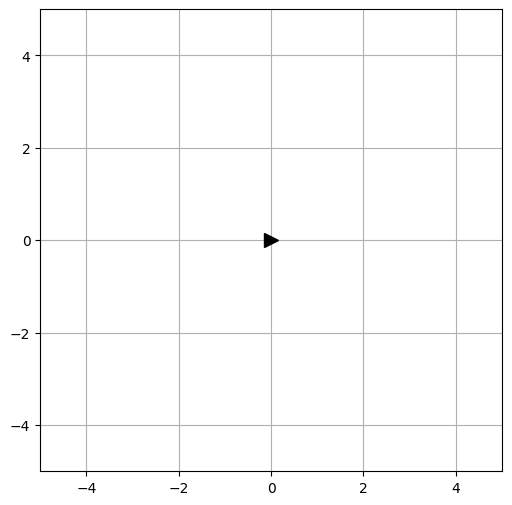

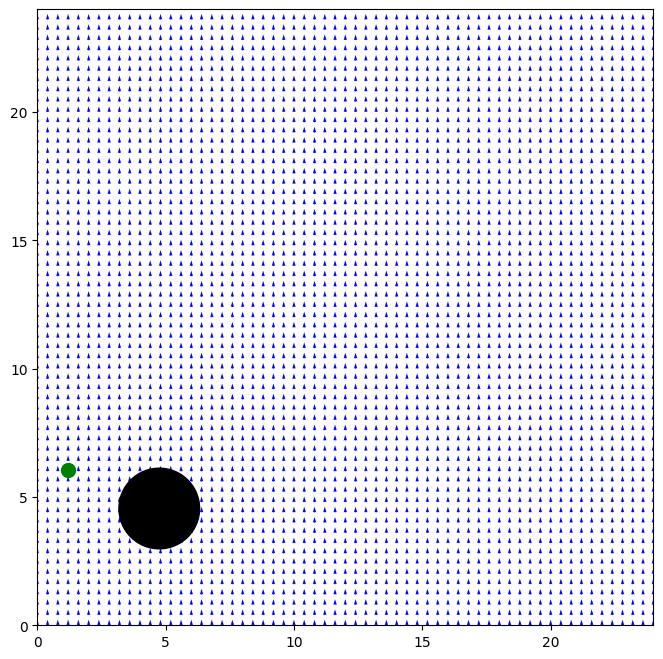

Posição do robô:  [1.3626542264386035, -4.7378512793301155, 0.1386886587550007]
Laser pos ->  [1.3617046088647495, -4.721088116656792, 0.2886887877375756]
Laser ori ->  [0.0018441690262183384, 0.00027055043641413984, 1.7518100299757409]


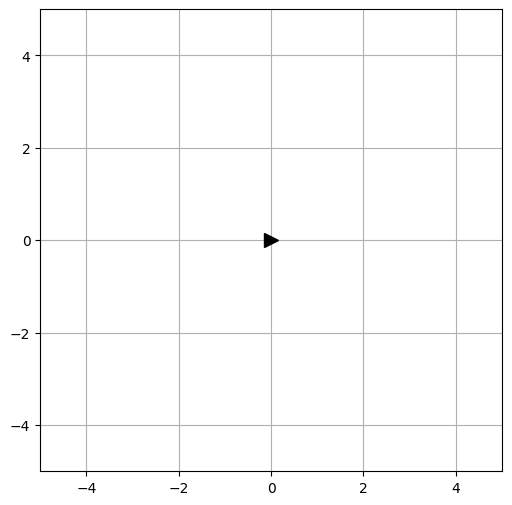

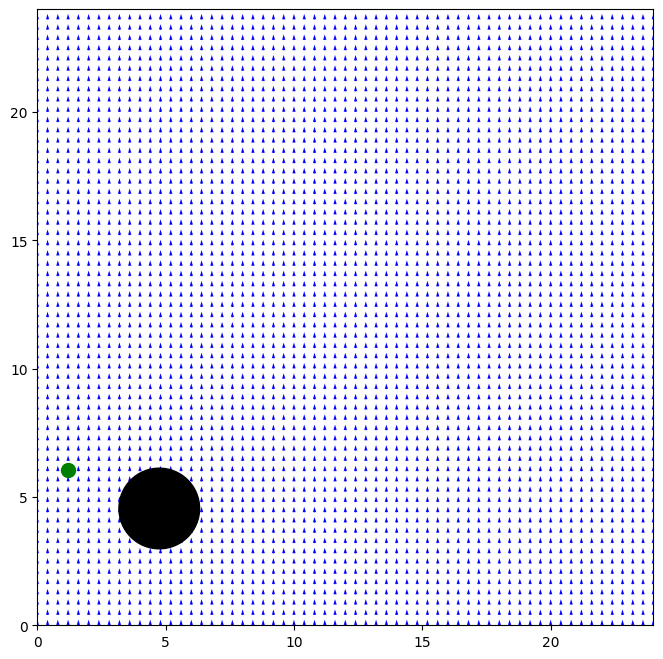

Posição do robô:  [1.3462771297958005, -4.650907750647464, 0.13868748057073993]
Laser pos ->  [1.3444713940927924, -4.641391241784825, 0.2886872549519157]
Laser ori ->  [0.001931185035663341, -0.00013252146381964258, 1.5447683266806063]


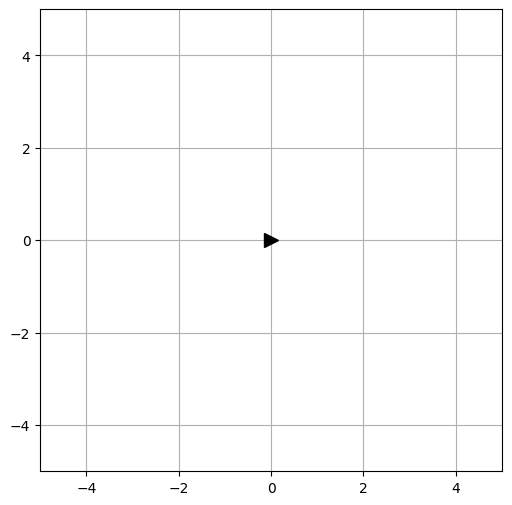

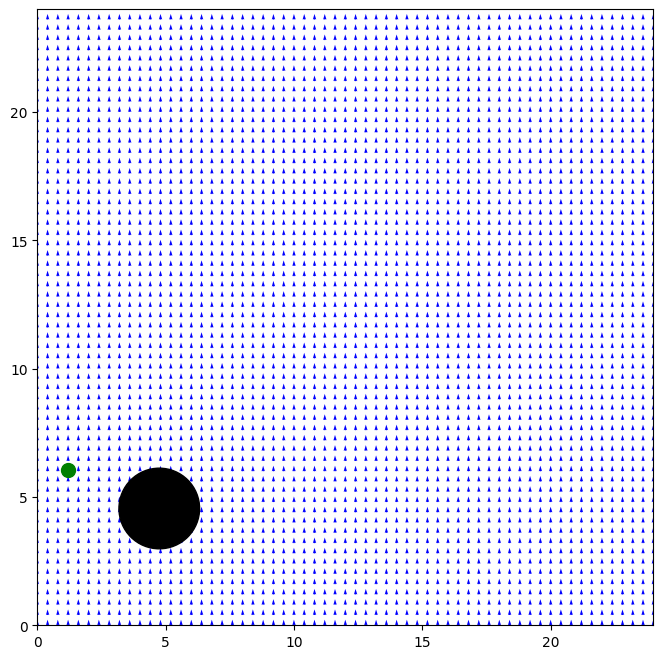

Posição do robô:  [1.3467690085164525, -4.568333182884183, 0.13869399466258123]
Laser pos ->  [1.34741367736054, -4.557762460966935, 0.2886910791432824]
Laser ori ->  [0.001828229945080336, -9.08930838987991e-05, 1.5606302270598154]


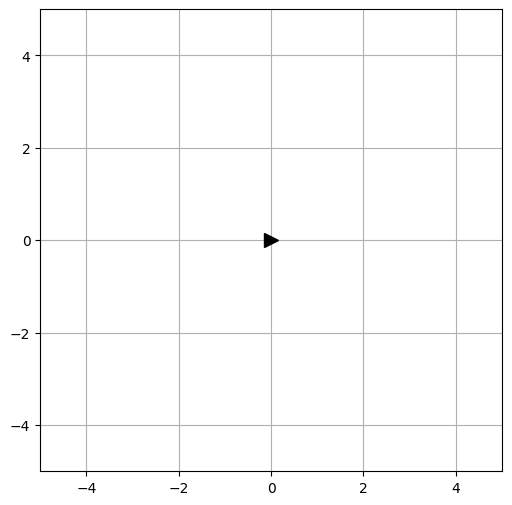

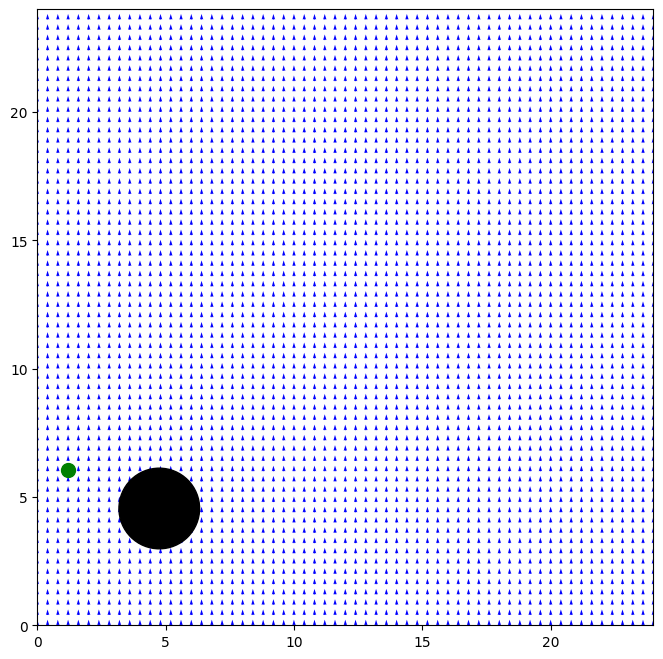

Posição do robô:  [1.3487717177651446, -4.48224147747789, 0.13869098052264525]
Laser pos ->  [1.3486024976090594, -4.46643301645456, 0.28869072080136665]
Laser ori ->  [0.0018221577301059382, 8.506826692865162e-06, 1.6144811017539344]


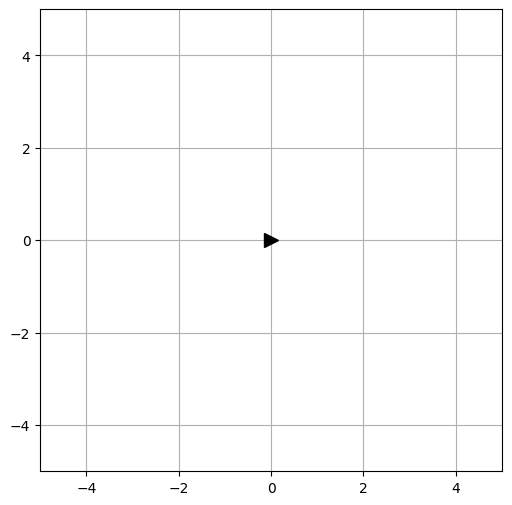

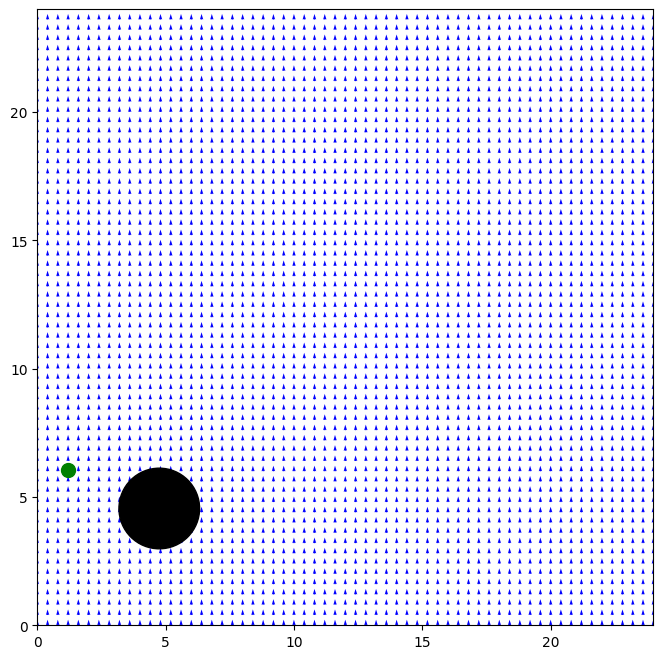

Posição do robô:  [1.3450048911932166, -4.393151671861409, 0.13869107458611007]
Laser pos ->  [1.3444705432326887, -4.377867449093288, 0.2886907979337328]
Laser ori ->  [0.0018234721292760647, -7.294842063441079e-05, 1.5727174409205438]


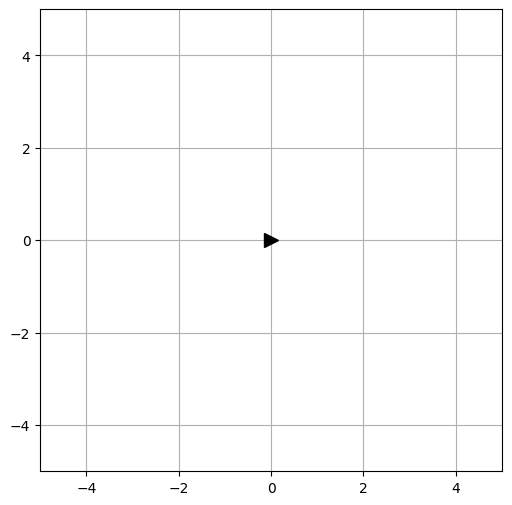

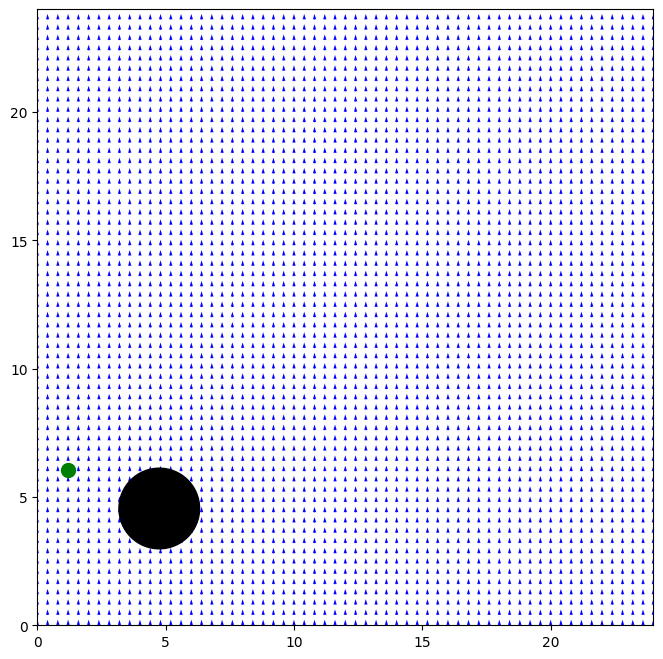

Posição do robô:  [1.3447068225103576, -4.309343260253292, 0.13869293837675037]
Laser pos ->  [1.3446609410363364, -4.299136749927158, 0.2886909012413499]
Laser ori ->  [0.0018171237337910474, -3.3496434365380326e-05, 1.5924517668955607]


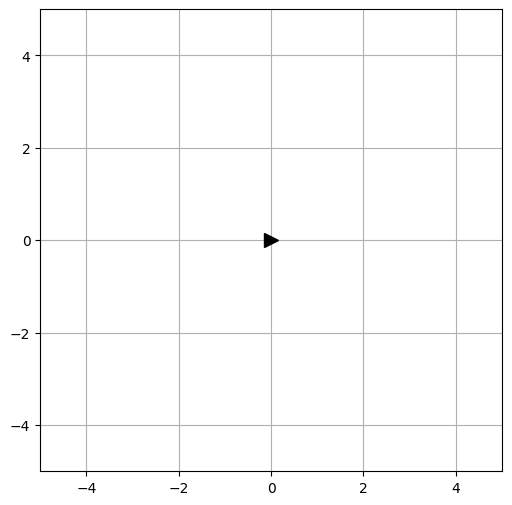

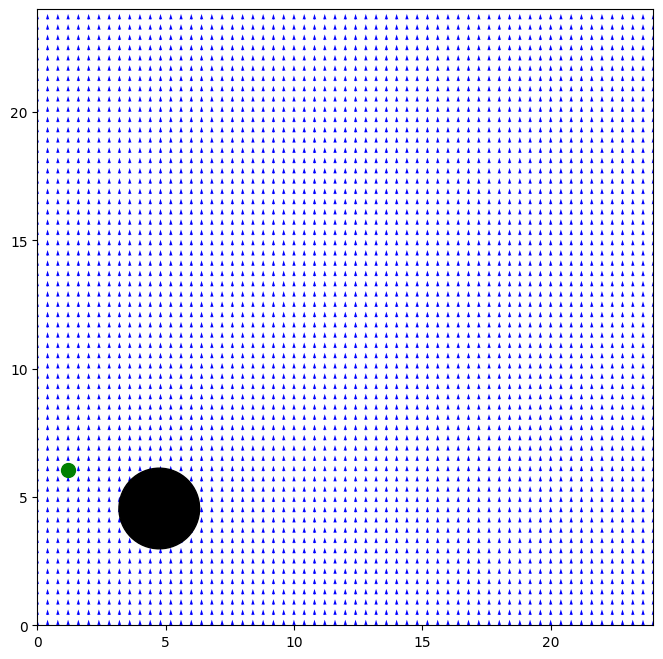

Posição do robô:  [1.343029097341626, -4.226479569646129, 0.13869134437763345]
Laser pos ->  [1.342804111623582, -4.216446977065044, 0.28869108571959645]
Laser ori ->  [0.0018183458419317106, -4.674476772893544e-05, 1.5861334896652142]


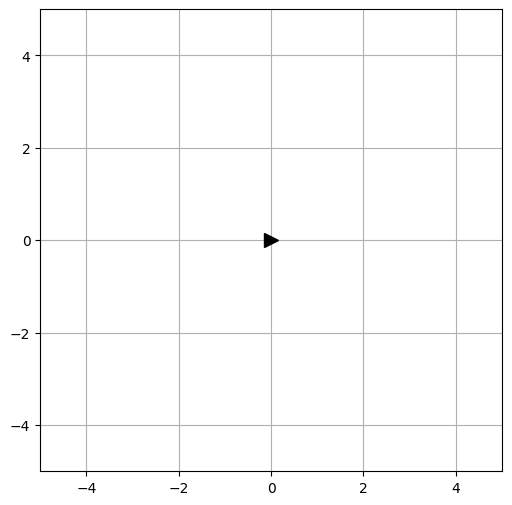

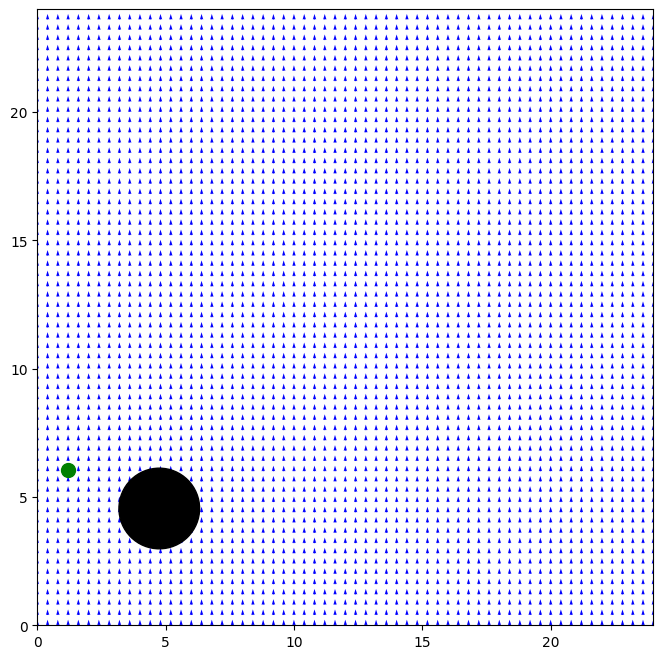

Posição do robô:  [1.34182906130912, -4.1494332971302335, 0.13869137698951012]
Laser pos ->  [1.3415118853374959, -4.129189621765303, 0.28869112283901055]
Laser ori ->  [0.0018173757699508177, -4.45788637606592e-05, 1.5872816405090973]


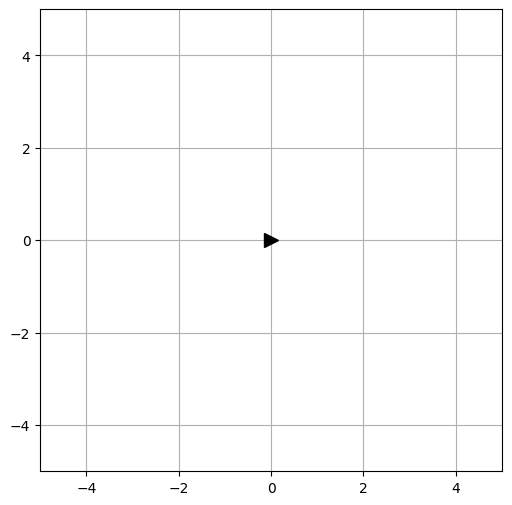

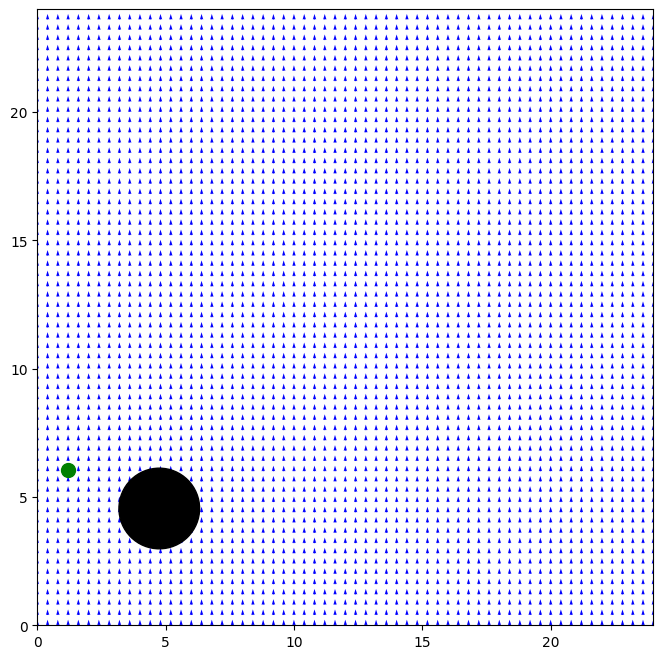

Posição do robô:  [1.3404242939803017, -4.062697037561041, 0.13869136235679666]
Laser pos ->  [1.3402503880790073, -4.052797639196358, 0.2886911013584482]
Laser ori ->  [0.0018172645209037991, -4.5081071284695084e-05, 1.587175716296242]


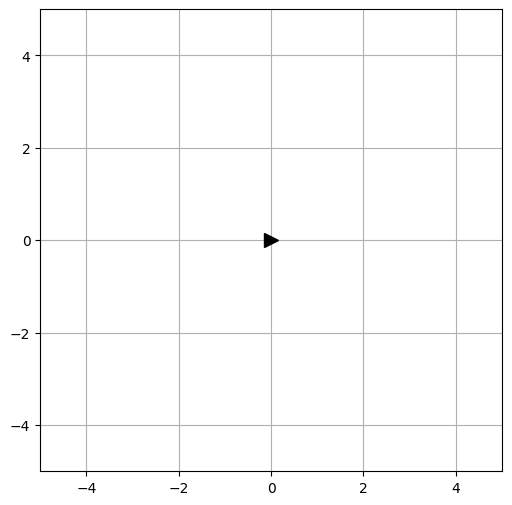

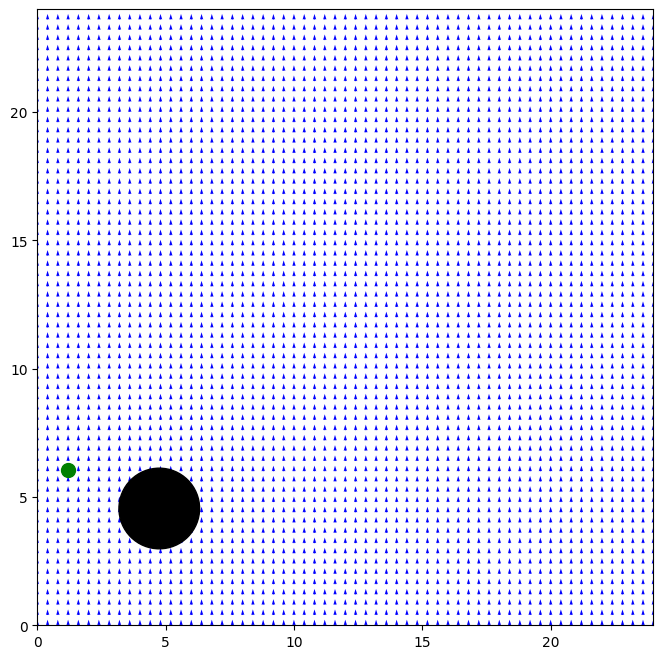

Posição do robô:  [1.339019615889058, -3.97671244891304, 0.13869133336730438]
Laser pos ->  [1.3387674181345113, -3.9618498631966905, 0.2886910665064587]
Laser ori ->  [0.0018167371053430998, -4.535928469730775e-05, 1.5870751507334844]


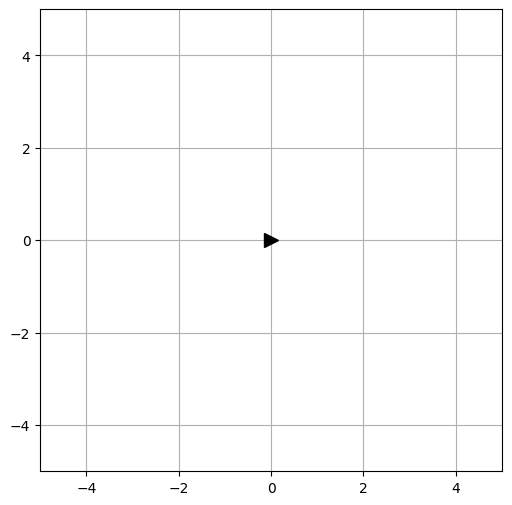

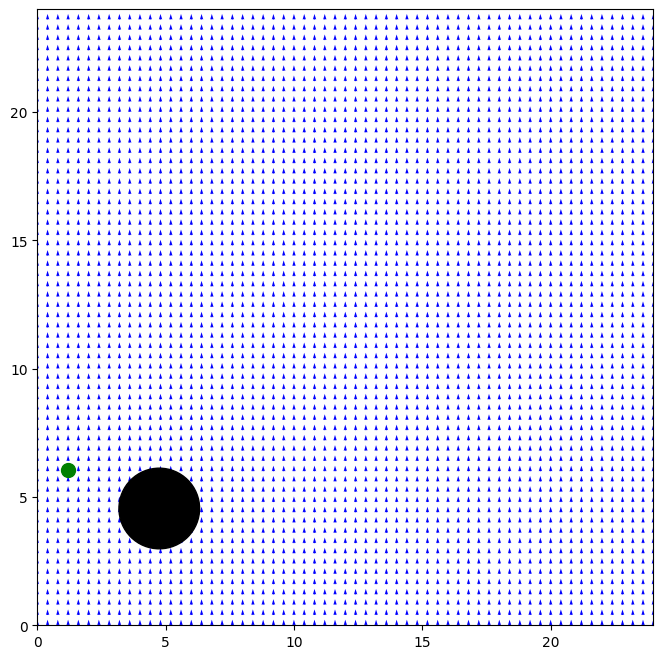

Posição do robô:  [1.3376385248042495, -3.8914148833699977, 0.13869122217021324]
Laser pos ->  [1.3373893957909941, -3.8766850714364467, 0.28869096226419133]
Laser ori ->  [0.0018179859199860253, -4.44660866205259e-05, 1.5871862676286959]


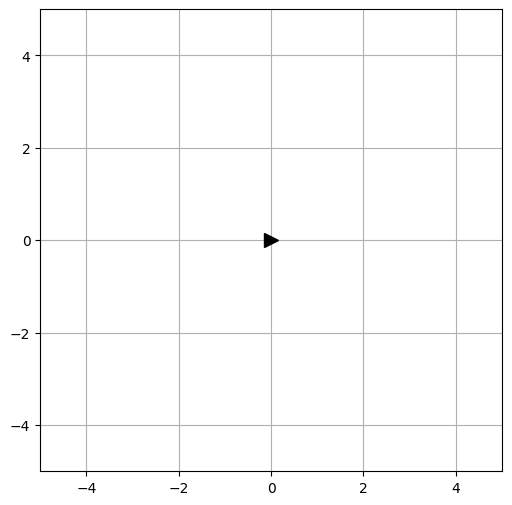

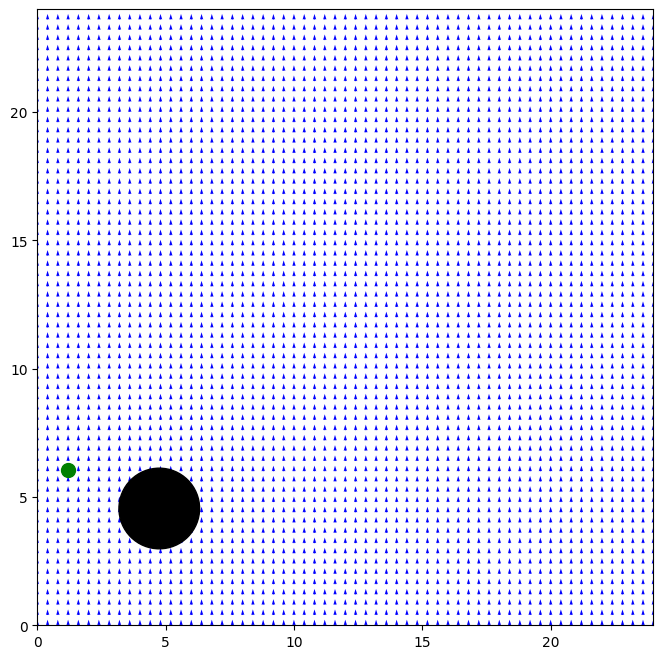

Posição do robô:  [1.3363408860448656, -3.8118702090856105, 0.1386912244524981]
Laser pos ->  [1.3360919423746185, -3.7972685520930654, 0.2886909715123721]
Laser ori ->  [0.0018178353503013125, -4.430663988133146e-05, 1.58715566176612]


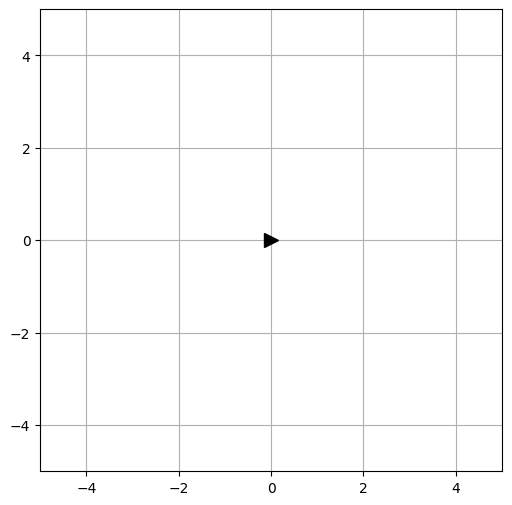

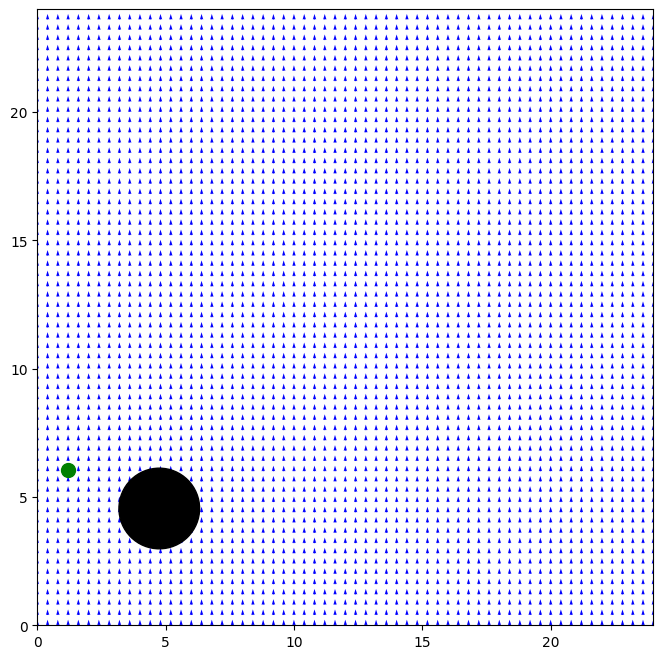

Posição do robô:  [1.335053999488664, -3.73297047714838, 0.13869125881871802]
Laser pos ->  [1.3347270749595954, -3.7135658870695116, 0.28869101351720694]
Laser ori ->  [0.0018178748035397945, -4.4170596308103575e-05, 1.5871544997361071]


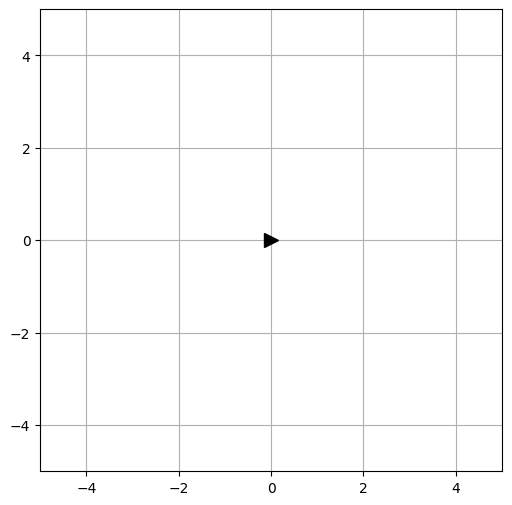

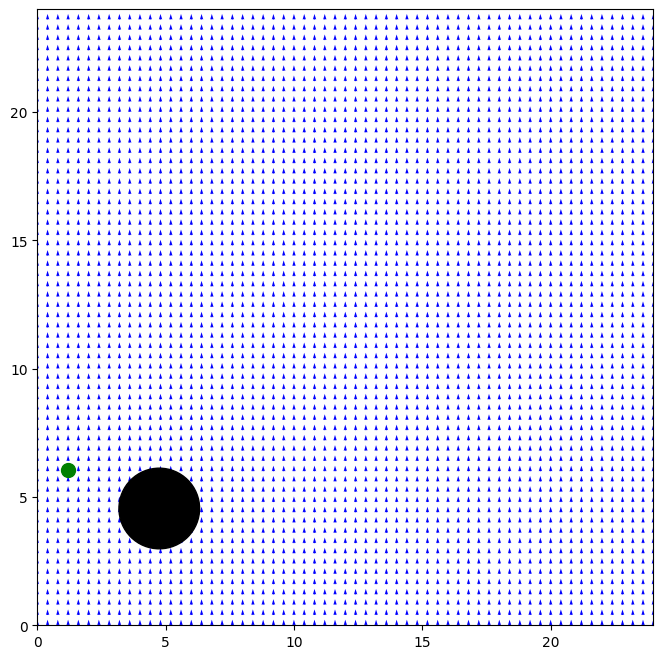

Posição do robô:  [1.333696979431308, -3.6497776613776445, 0.13869131069337312]
Laser pos ->  [1.3333725262234861, -3.6305298011060883, 0.2886910645659489]
Laser ori ->  [0.001817954671730383, -4.4252358553577e-05, 1.5871513559572037]


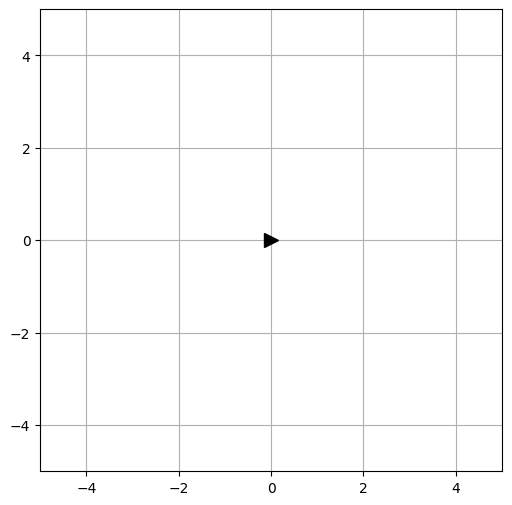

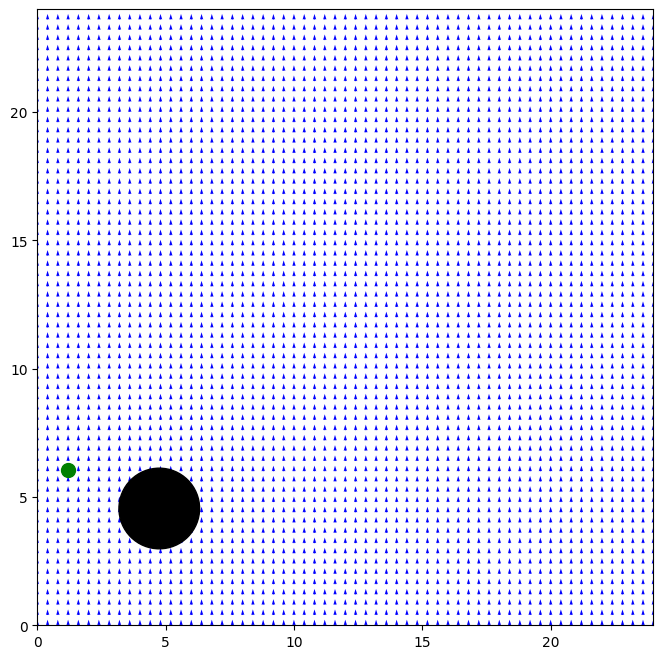

Posição do robô:  [1.3322725546021046, -3.5624357465889034, 0.13869134675171158]
Laser pos ->  [1.3320298766468537, -3.5481939670834457, 0.28869109251962854]
Laser ori ->  [0.0018179364223587502, -4.449294931995568e-05, 1.5871484594373206]


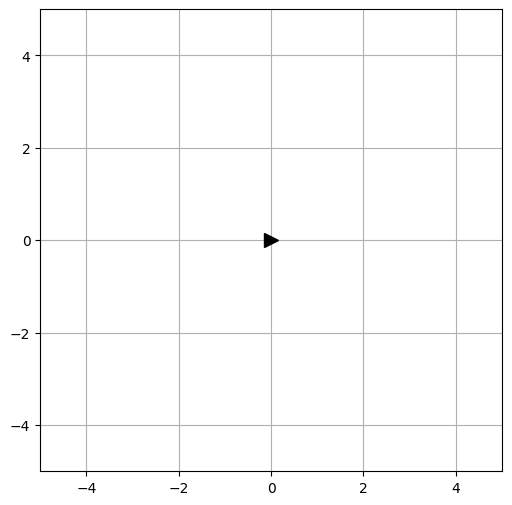

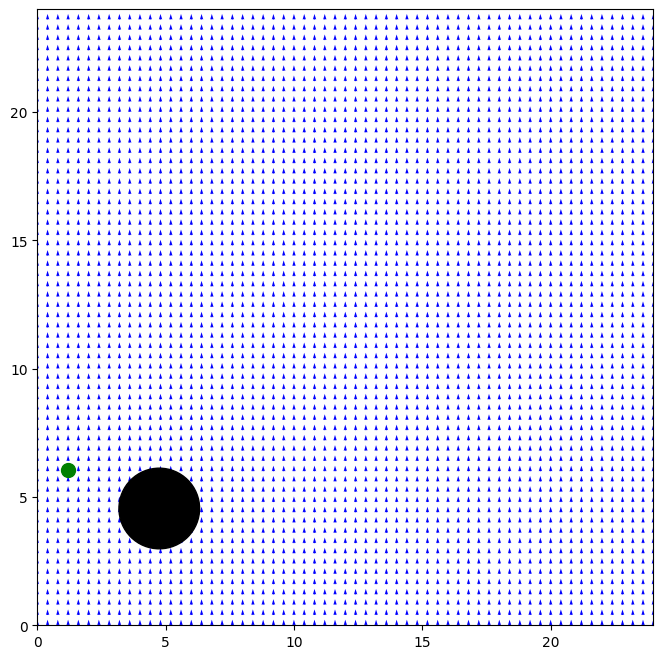

Posição do robô:  [1.3298581781738985, -3.413496102769853, 0.13869139976313222]
Laser pos ->  [1.329619911334659, -3.399374550383955, 0.2886911344365056]
Laser ori ->  [0.0018165943011678048, -4.605801840178783e-05, 1.5872278724115982]


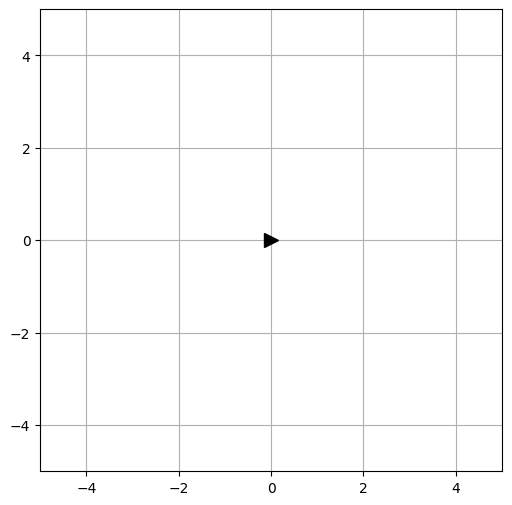

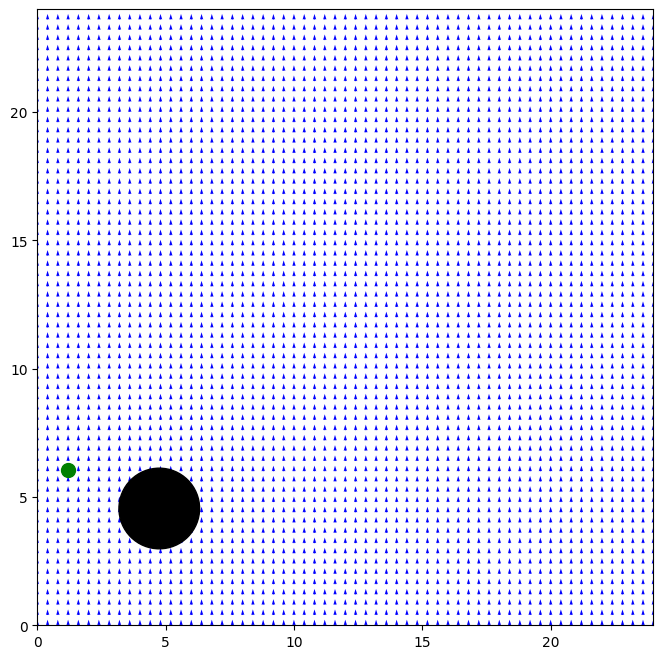

Posição do robô:  [1.3285561283394314, -3.3327738438518586, 0.13869135380170788]
Laser pos ->  [1.3283205575825399, -3.3188763611998064, 0.2886910901361103]
Laser ori ->  [0.0018163600112845043, -4.598865034330639e-05, 1.5871893133339234]


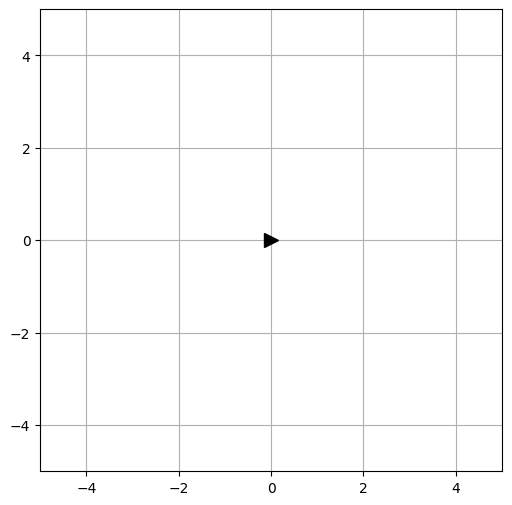

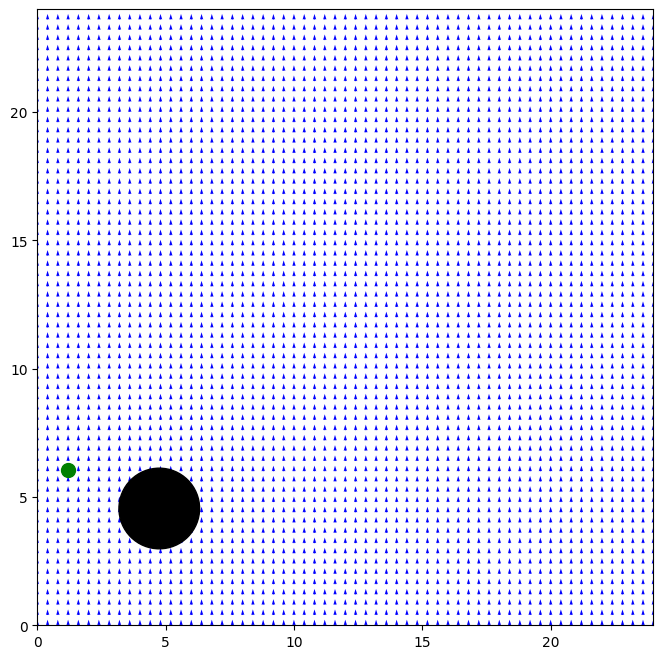

Posição do robô:  [1.327342596063177, -3.2576367042336623, 0.1386913372315502]
Laser pos ->  [1.3271091563825994, -3.2438599061780247, 0.28869107856136034]
Laser ori ->  [0.0018162764078243215, -4.6035131206032925e-05, 1.587176465733711]


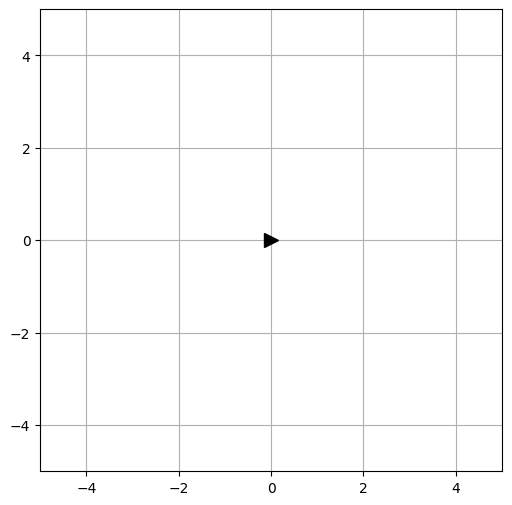

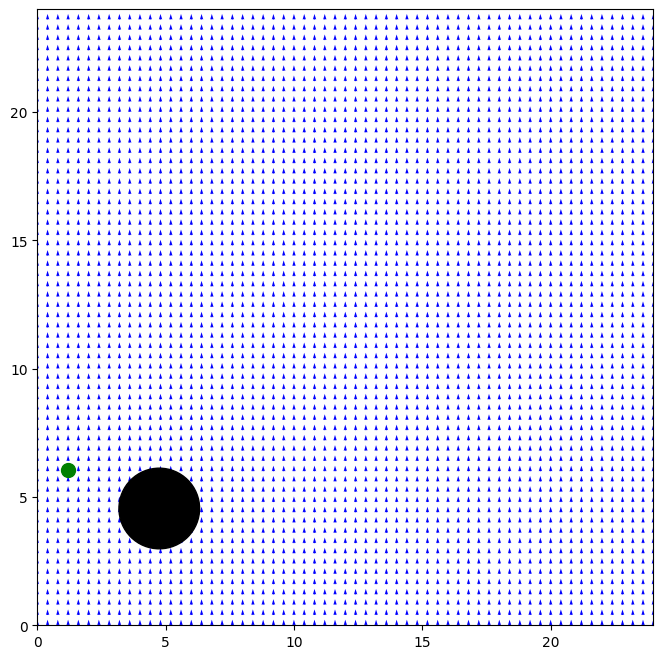

Posição do robô:  [1.3261397097411989, -3.183110863126152, 0.1386913402121323]
Laser pos ->  [1.3259832329612269, -3.1740949601028183, 0.28869108587519865]
Laser ori ->  [0.00181631330735173, -4.57258022061776e-05, 1.587208686939145]


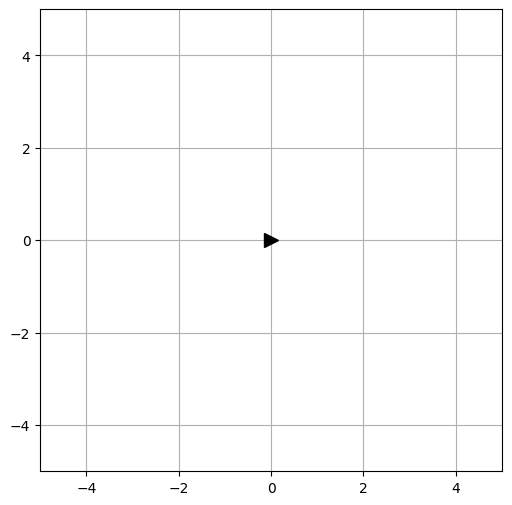

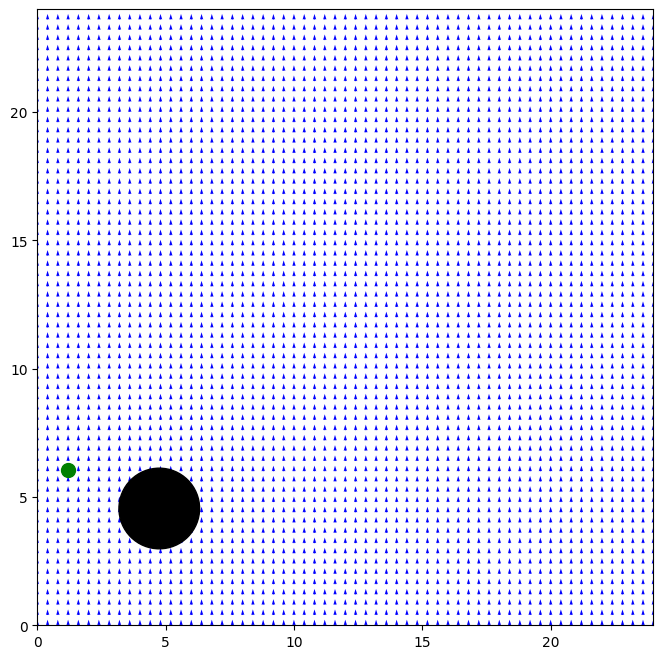

Posição do robô:  [1.3249432591365462, -3.1091832352862285, 0.13869136947619437]
Laser pos ->  [1.3247128848605874, -3.095631004258634, 0.2886911198032247]
Laser ori ->  [0.001816517183493178, -4.5571423987250624e-05, 1.5872093109375718]


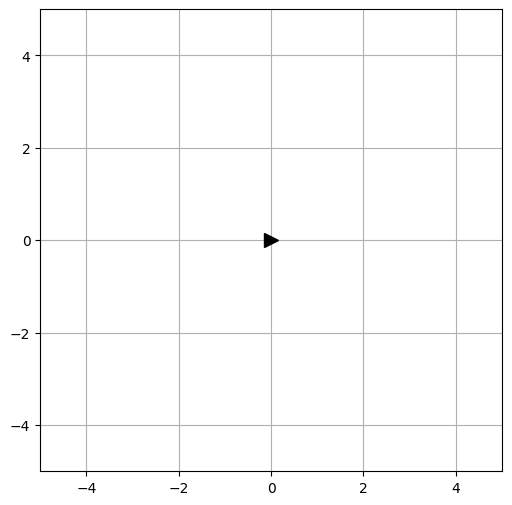

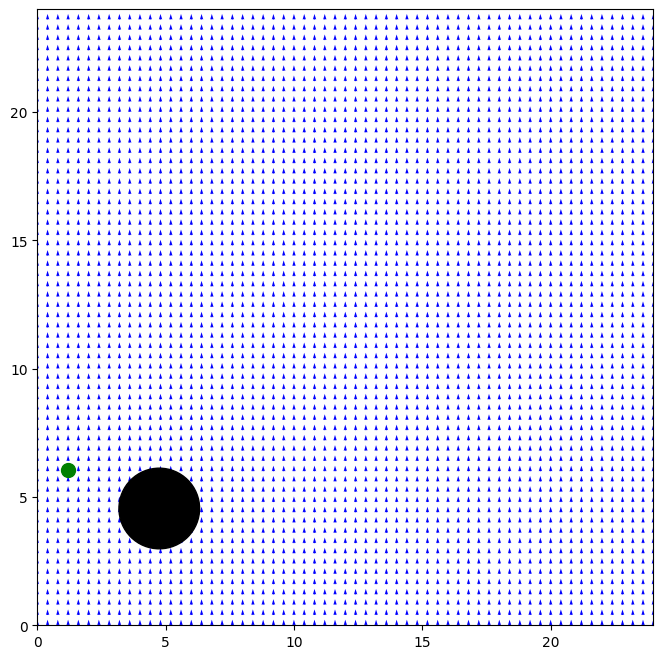

Posição do robô:  [1.3236066935105895, -3.02666334788025, 0.13869141169635424]
Laser pos ->  [1.323378010004987, -3.013221985667578, 0.28869116059640954]
Laser ori ->  [0.0018167605172043756, -4.5563673405544106e-05, 1.5872328034708139]


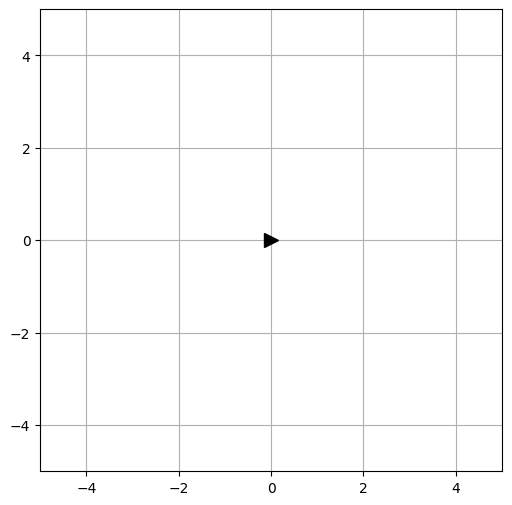

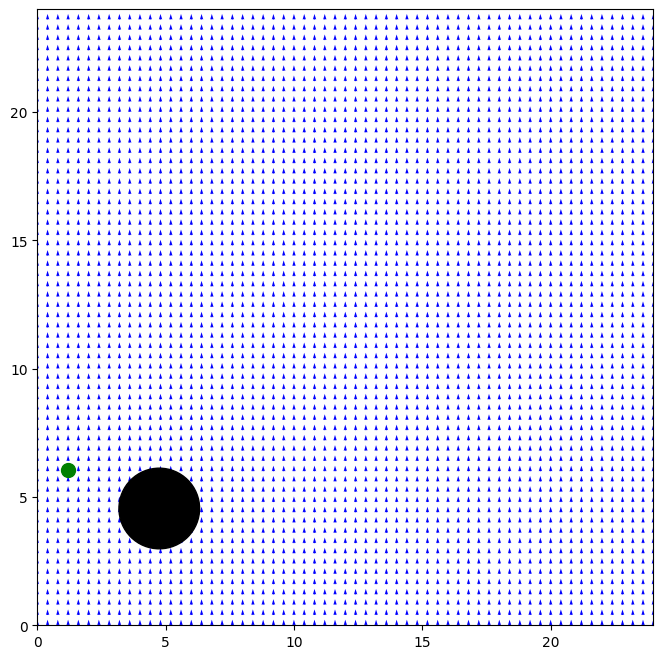

Posição do robô:  [1.3223532796778374, -2.9494172079203187, 0.1386914297420973]
Laser pos ->  [1.322200471743095, -2.9406357709206508, 0.2886911734656984]
Laser ori ->  [0.0018177363536007604, -4.6136851208031815e-05, 1.5870611649294497]


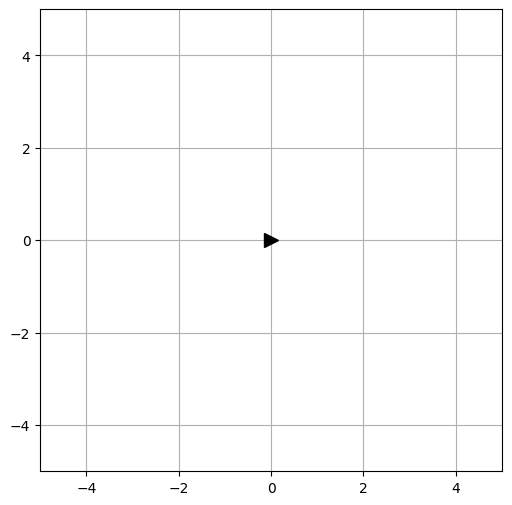

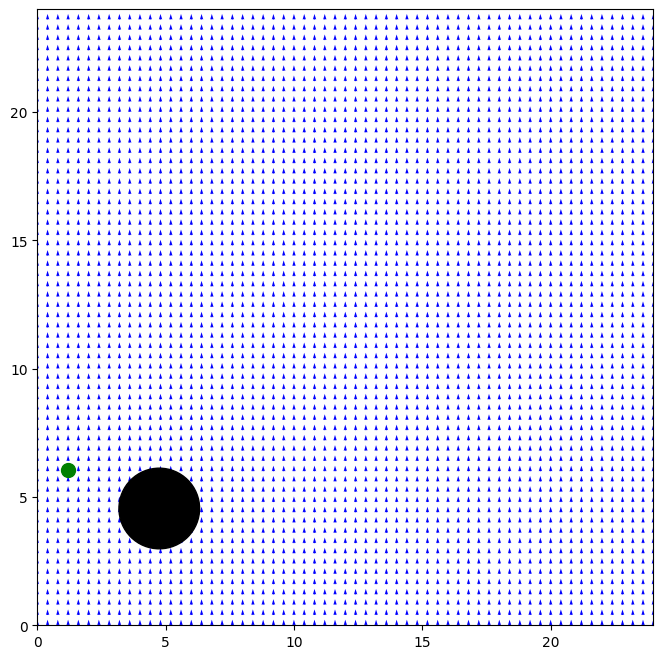

Posição do robô:  [1.3213437787183768, -2.886398721668254, 0.1386914274834027]
Laser pos ->  [1.3211210232592863, -2.8732007886239663, 0.28869116681973883]
Laser ori ->  [0.0018176585431979072, -4.6191123609150536e-05, 1.5871490391079452]


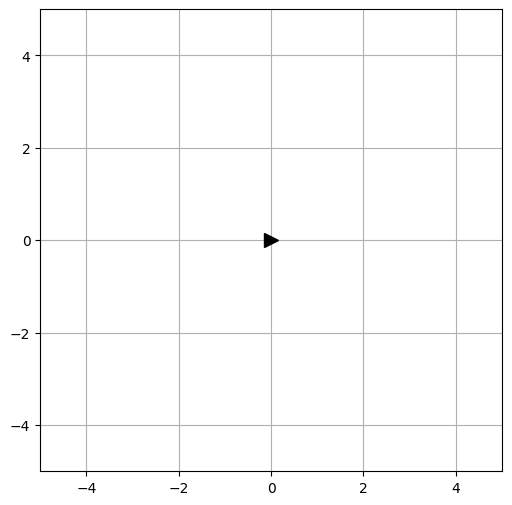

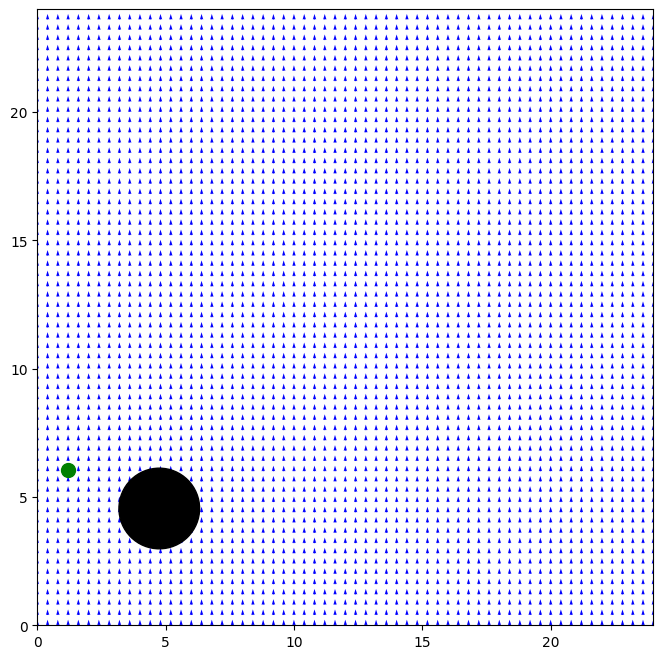

Posição do robô:  [1.3201904510454285, -2.8148902906323134, 0.13869139947217107]
Laser pos ->  [1.3200400352422803, -2.8062487821040887, 0.28869113760579357]
Laser ori ->  [0.0018174721760162989, -4.6416378350812646e-05, 1.5871049002044113]


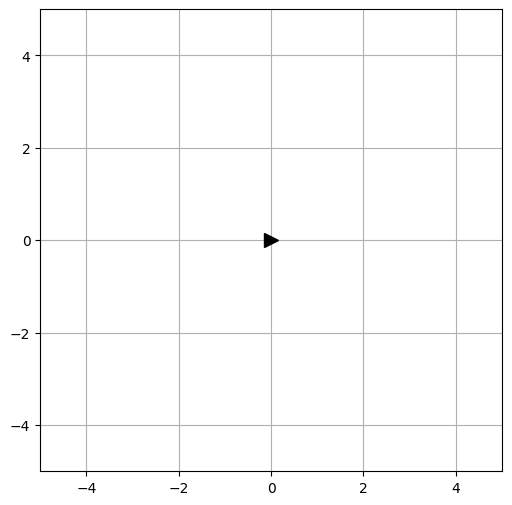

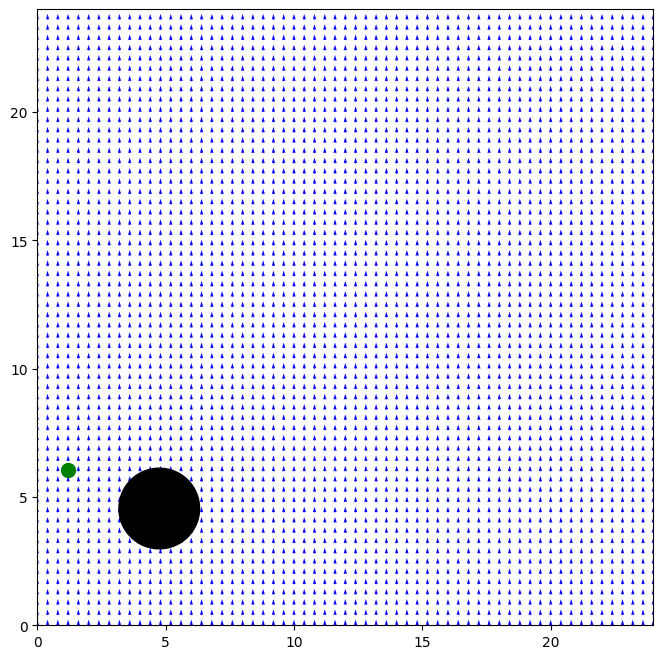

Posição do robô:  [1.319047505437847, -2.7439369141836507, 0.1386913603330244]
Laser pos ->  [1.318826995769249, -2.7309412058919733, 0.28869109622864986]
Laser ori ->  [0.0018172179512702868, -4.637120505529409e-05, 1.587117212549699]


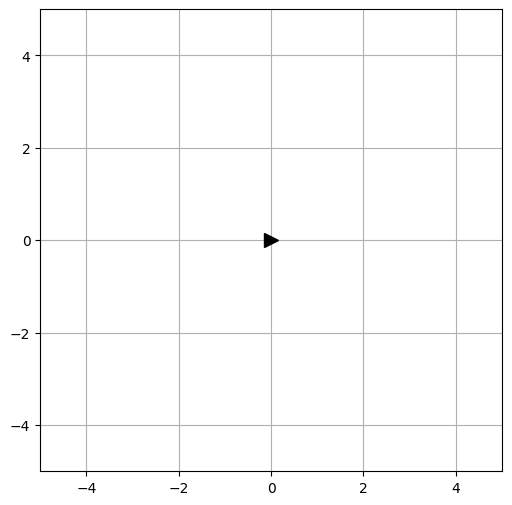

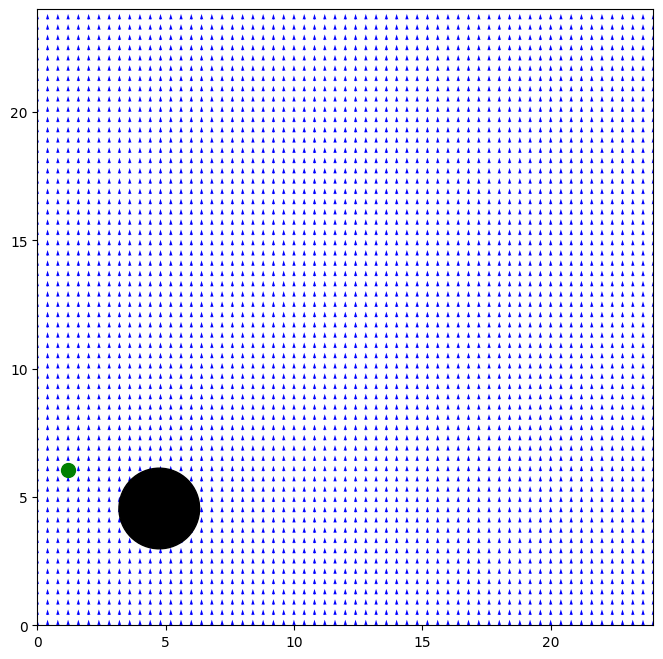

Posição do robô:  [1.3179829751855503, -2.6779427762903274, 0.13869133069331027]
Laser pos ->  [1.317763825272145, -2.6650536569792482, 0.2886910698956297]
Laser ori ->  [0.001817037907291315, -4.622837745375497e-05, 1.587104578904964]


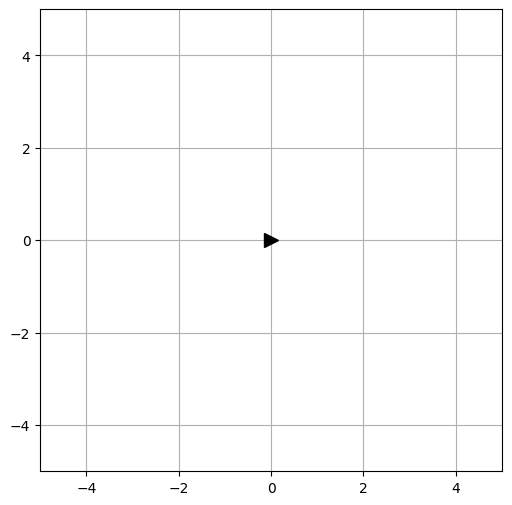

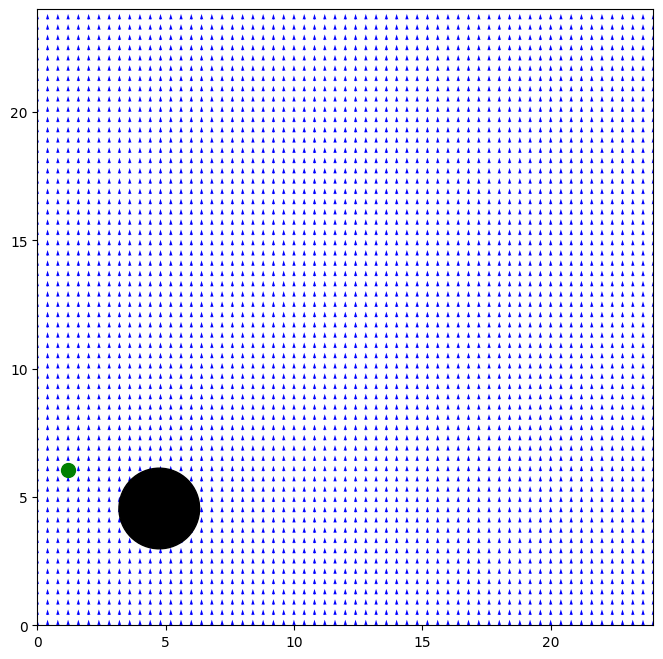

Posição do robô:  [1.3167844092134495, -2.6037070588332716, 0.13869132195739683]
Laser pos ->  [1.3164962896664312, -2.5865599609986694, 0.2886910674439652]
Laser ori ->  [0.0018170057955994583, -4.598078712119133e-05, 1.5871009191969196]


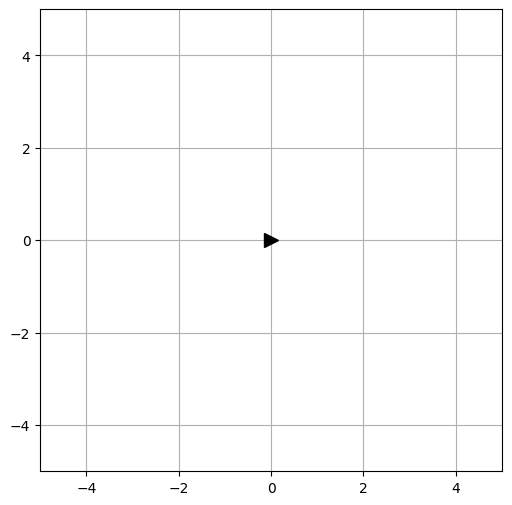

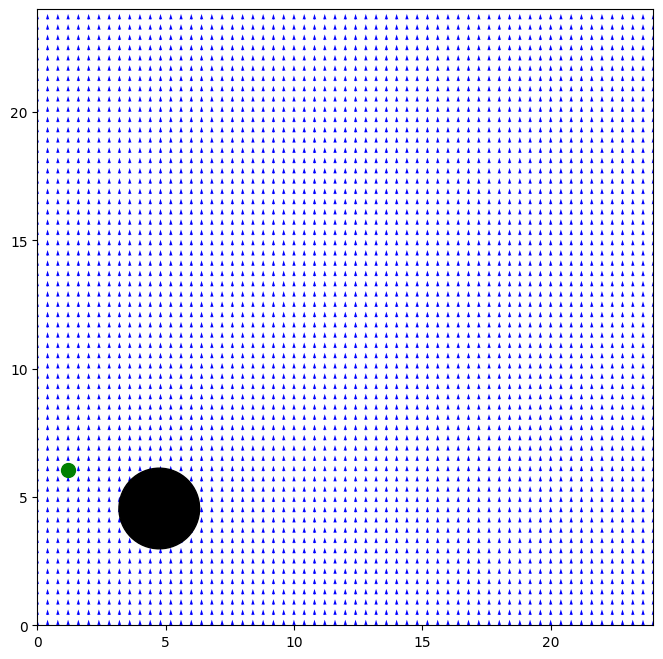

Posição do robô:  [1.3155243037868756, -2.525724979242233, 0.1386913449195404]
Laser pos ->  [1.3153083083773254, -2.5130463150844036, 0.2886910941608983]
Laser ori ->  [0.0018171471546445702, -4.581838159695632e-05, 1.587095543152492]


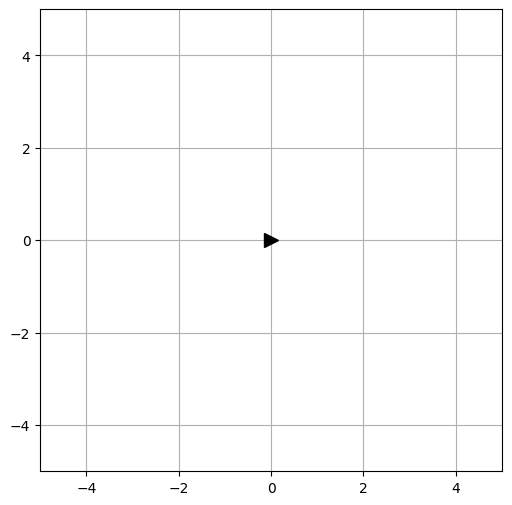

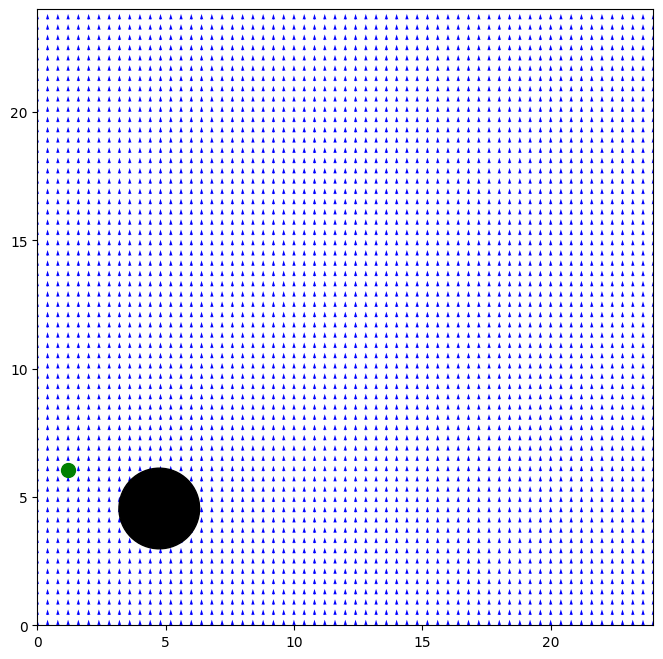

Posição do robô:  [1.3142749291885312, -2.4484729776329983, 0.138691386174774]
Laser pos ->  [1.3140606540021742, -2.435911405120486, 0.28869113606814734]
Laser ori ->  [0.001817376181480627, -4.581441324144023e-05, 1.5870891748288534]


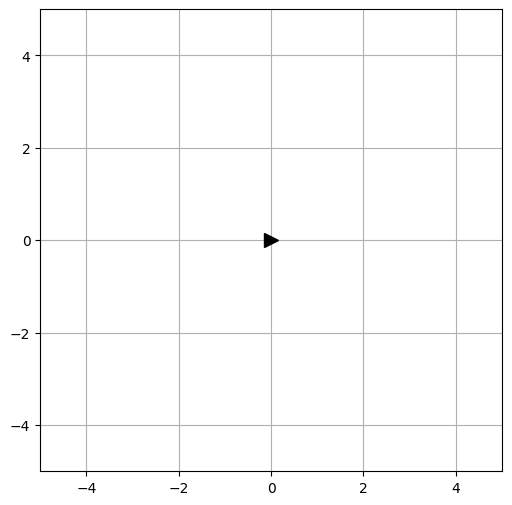

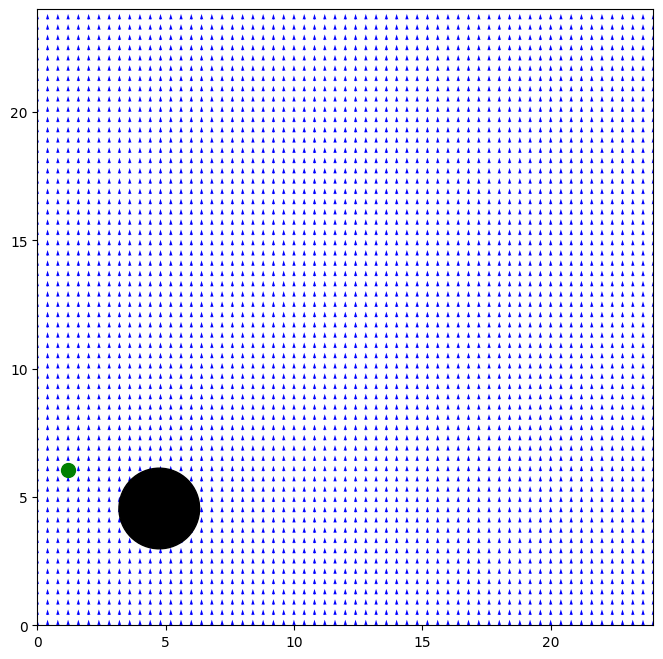

Posição do robô:  [1.3131047054247555, -2.3761610457029994, 0.13869141893288764]
Laser pos ->  [1.3128233206250919, -2.359473357476805, 0.28869116675800854]
Laser ori ->  [0.001817544532518781, -4.597245495323159e-05, 1.5870824520813926]


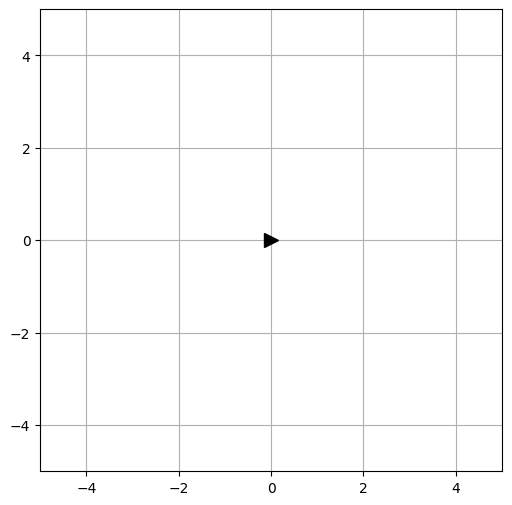

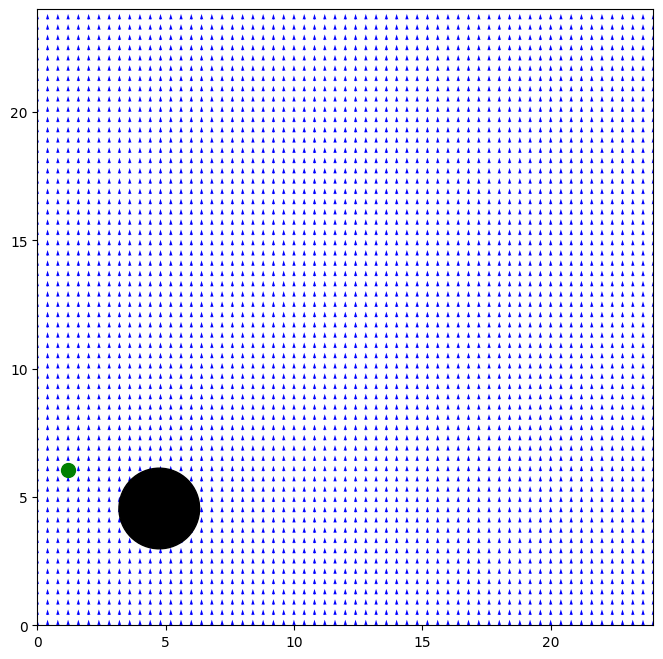

Posição do robô:  [1.3118749909225251, -2.3002348658438567, 0.13869142825823913]
Laser pos ->  [1.3116640796184205, -2.287897913165258, 0.28869116959397256]
Laser ori ->  [0.001817543078766964, -4.618179285016663e-05, 1.587078315835219]


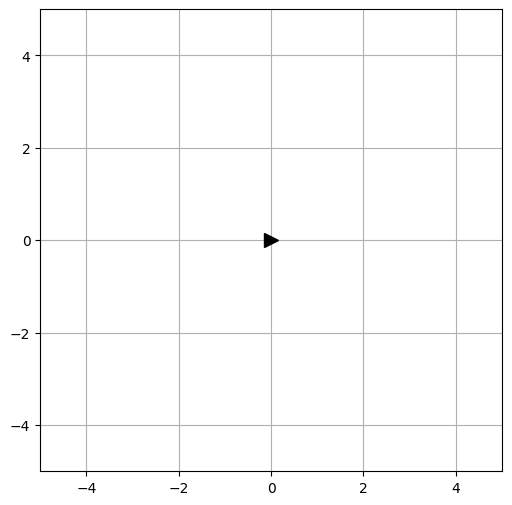

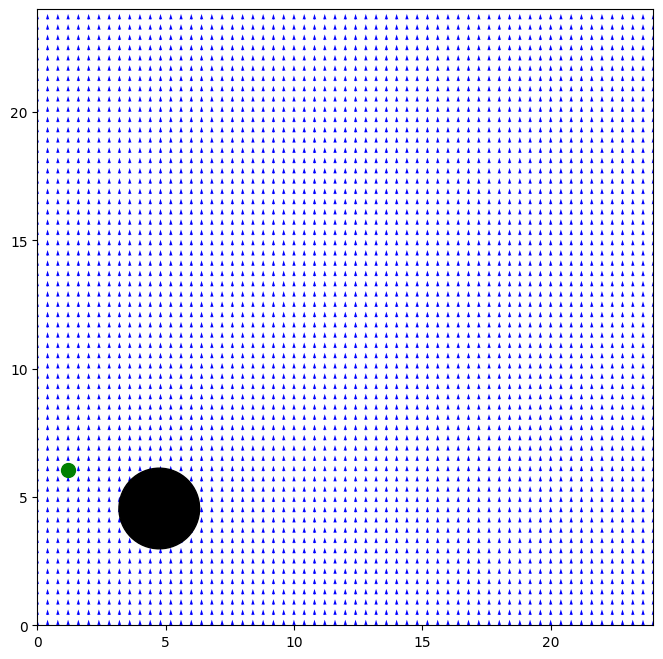

Posição do robô:  [1.3107238123760356, -2.2291871622159283, 0.13869140979512512]
Laser pos ->  [1.3105145593941898, -2.2169640150328, 0.2886911470408804]
Laser ori ->  [0.001817361456502783, -4.634283735331095e-05, 1.587079860304854]


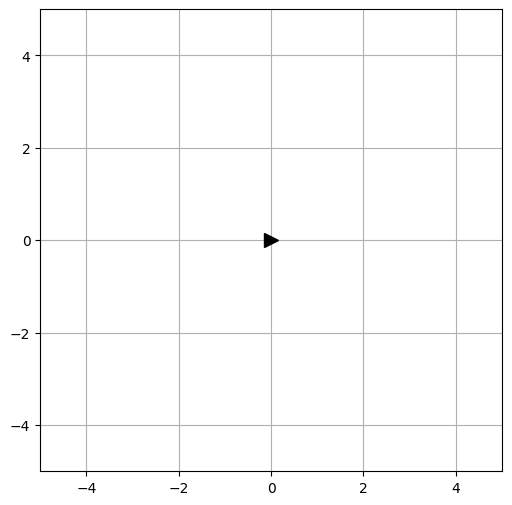

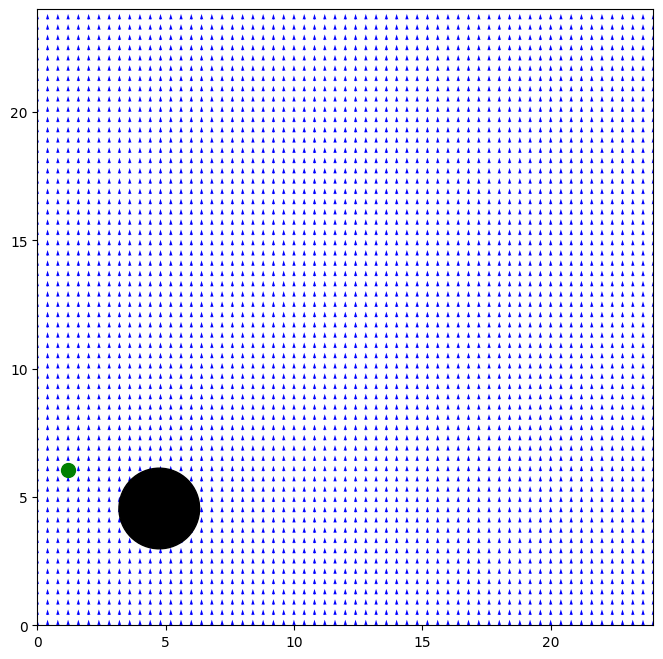

Posição do robô:  [1.3087748139057103, -2.109164371340166, 0.13869134864305593]
Laser pos ->  [1.308634294022283, -2.101180104527108, 0.2886910877507406]
Laser ori ->  [0.0018169158245326818, -4.633328243474001e-05, 1.5870788774229245]


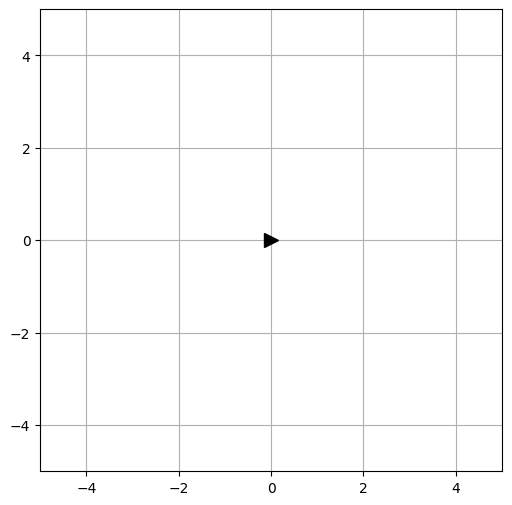

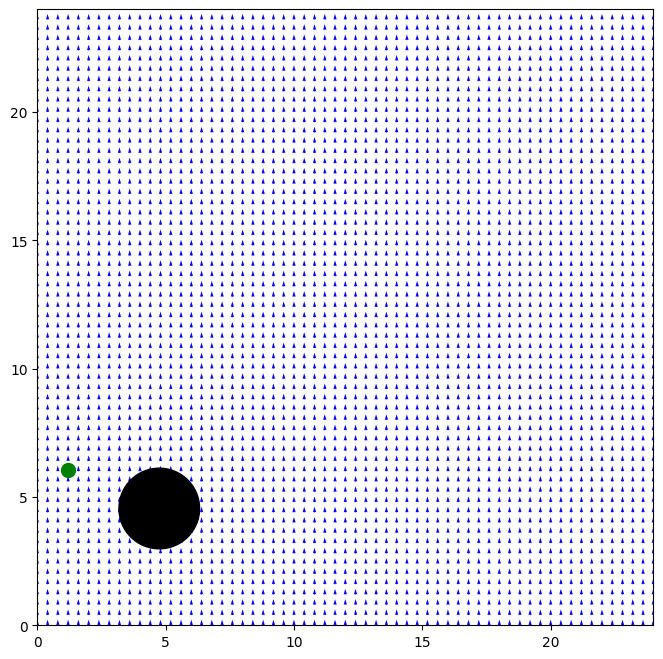

Posição do robô:  [1.307781850505308, -2.0478937697345083, 0.13869132650285776]
Laser pos ->  [1.307576976442189, -2.035956934297765, 0.28869106728992217]
Laser ori ->  [0.0018167392316423858, -4.613573068594123e-05, 1.5870827821886622]


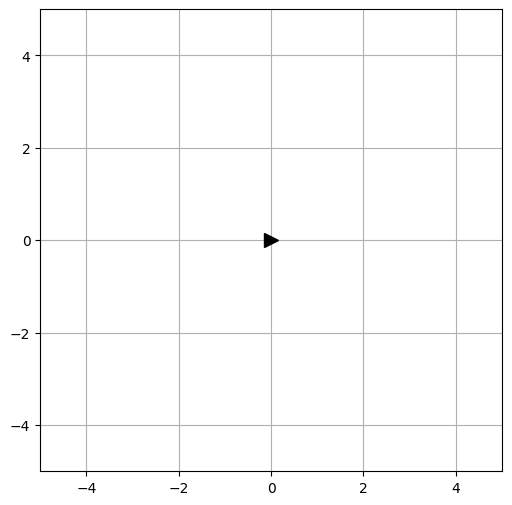

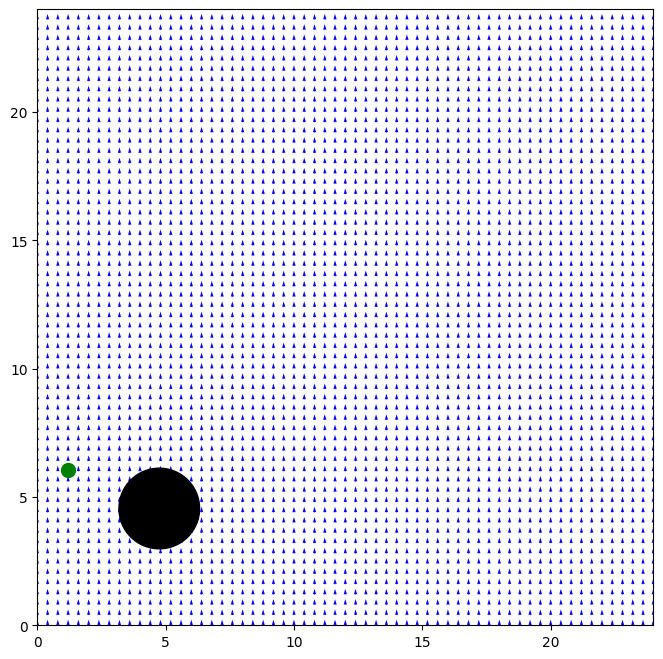

Posição do robô:  [1.3066629300749033, -1.979027261268906, 0.1386913245901571]
Laser pos ->  [1.30645956891159, -1.9671823854653032, 0.28869107017153106]
Laser ori ->  [0.0018167224449665714, -4.592576195981055e-05, 1.5870738602267622]


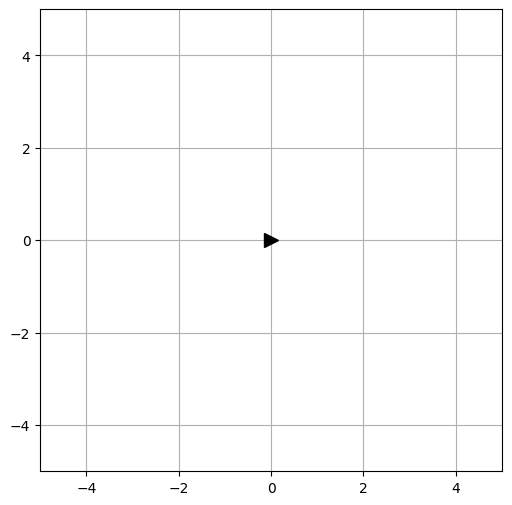

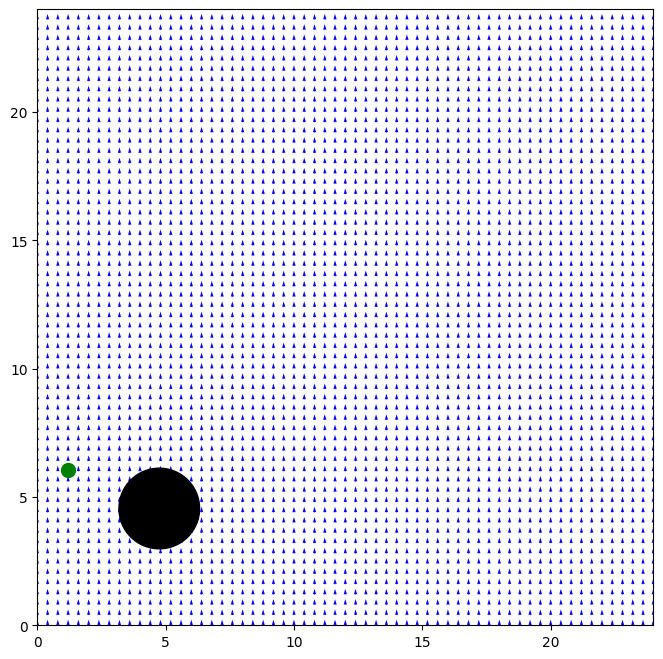

Posição do robô:  [1.3055537089301001, -1.9107258606111088, 0.1386913493538781]
Laser pos ->  [1.305352024359559, -1.898983963939088, 0.2886910984141945]
Laser ori ->  [0.001816818849765028, -4.5772121505431715e-05, 1.5870864156395743]


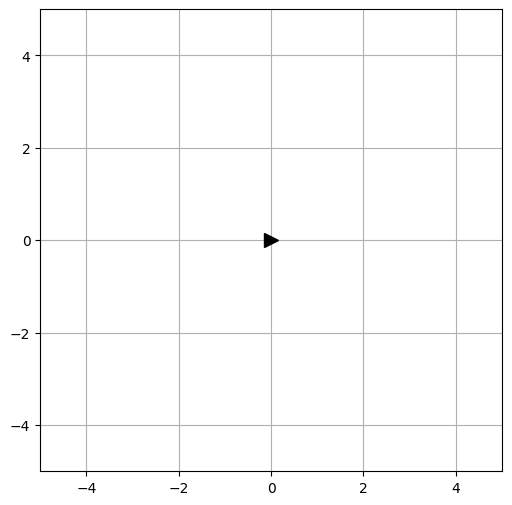

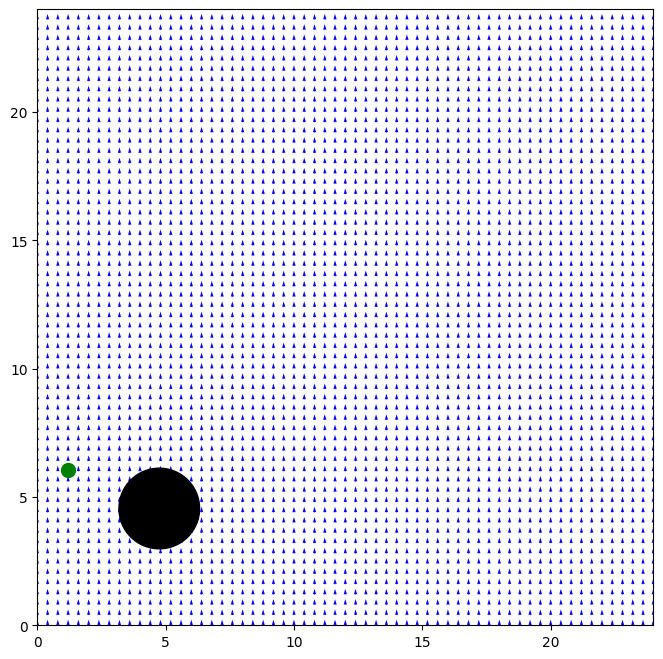

Posição do robô:  [1.3045826180050457, -1.8509864830024632, 0.13869138256119648]
Laser pos ->  [1.3044471362805152, -1.84332039405969, 0.2886911300641337]
Laser ori ->  [0.0018169746960840923, -4.575814219957916e-05, 1.5870837786141074]


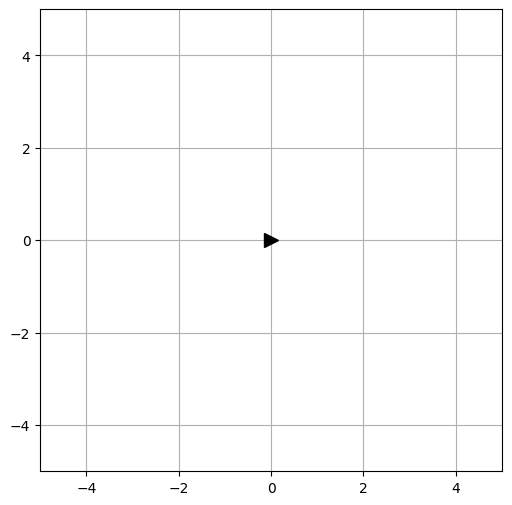

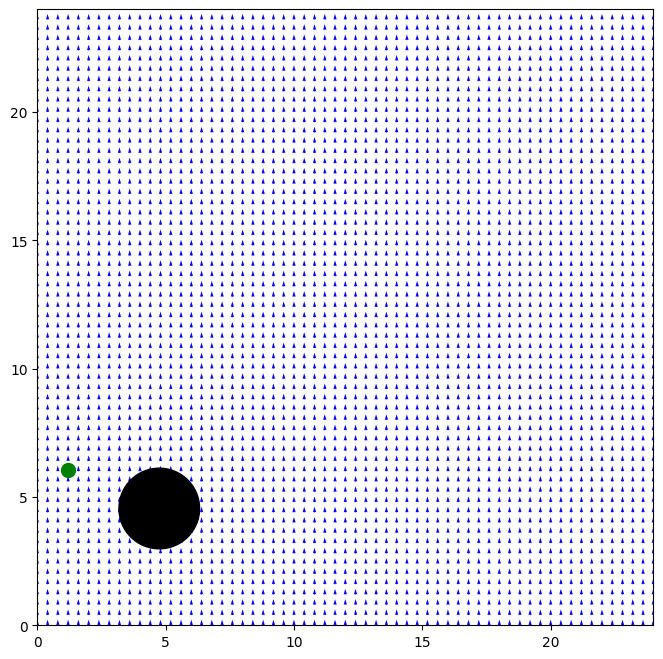

Posição do robô:  [1.3034903528089614, -1.7838252798421248, 0.13869152398779136]
Laser pos ->  [1.3032916997744353, -1.7722756159460438, 0.2886912770420256]
Laser ori ->  [0.001820045779508349, -4.697574780279556e-05, 1.587083845057342]


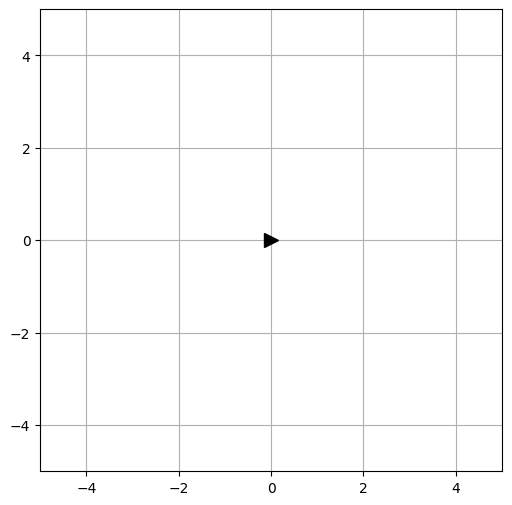

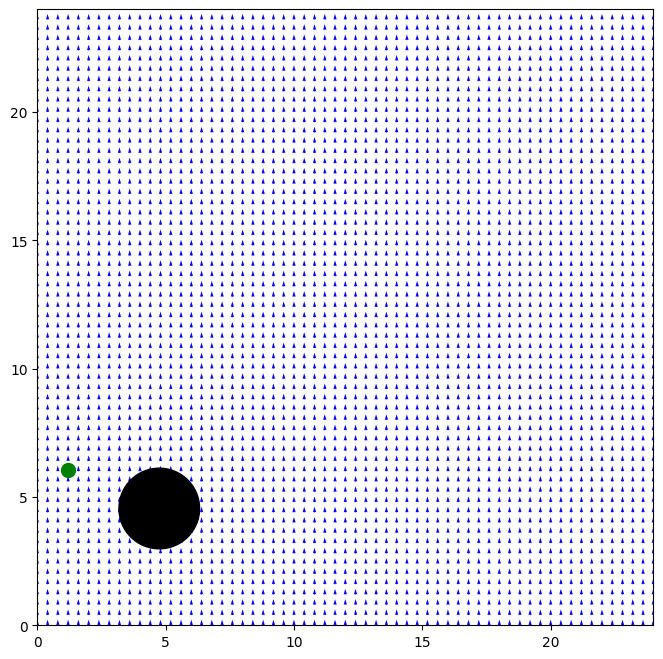

Posição do robô:  [1.3024086028335893, -1.7172182286996693, 0.13869154428913377]
Laser pos ->  [1.302211546088968, -1.7057691330008806, 0.2886912867560664]
Laser ori ->  [0.0018200489308386435, -4.7126608167130455e-05, 1.5870892724395127]


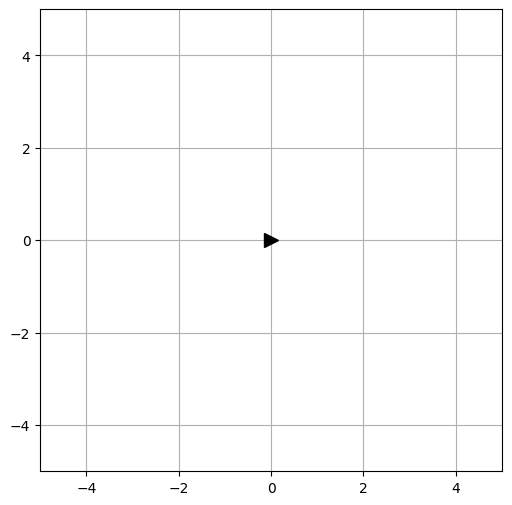

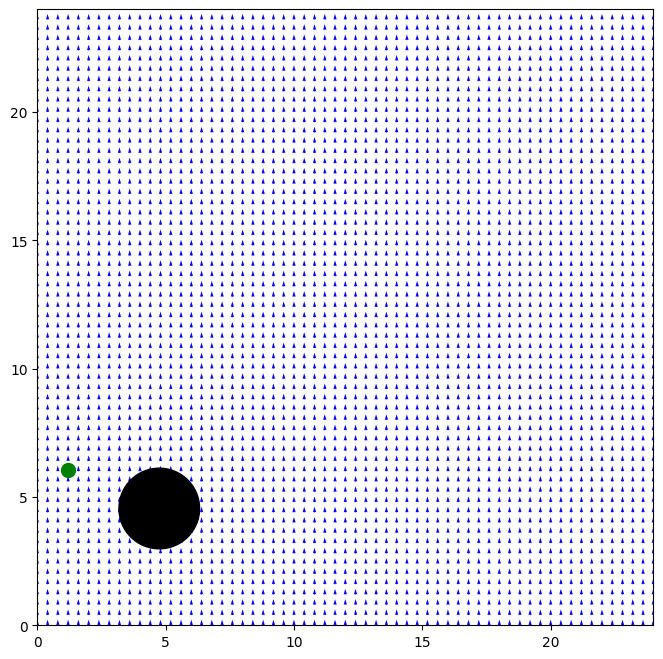

Posição do robô:  [1.3013987463238967, -1.6550544071372812, 0.1386915346430753]
Laser pos ->  [1.301203243089123, -1.6437050352282974, 0.2886912730841562]
Laser ori ->  [0.0018199127294760845, -4.727995427969506e-05, 1.5870910483719716]


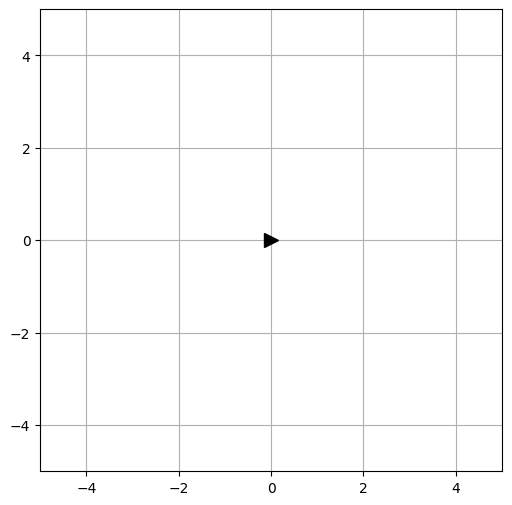

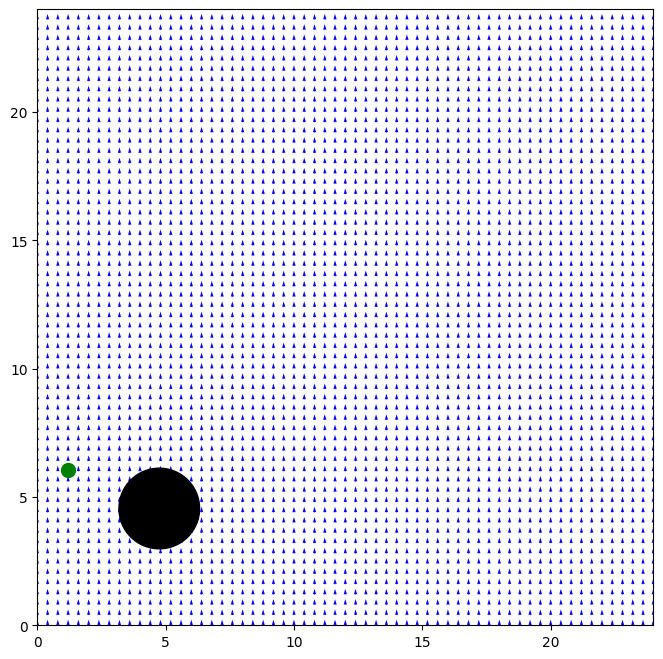

Posição do robô:  [1.3003338094981969, -1.5895187587940032, 0.1386915041291933]
Laser pos ->  [1.300077217125823, -1.5744164399102976, 0.28869123772219774]
Laser ori ->  [0.0018196493061677092, -4.7339685748203334e-05, 1.5870967069191695]


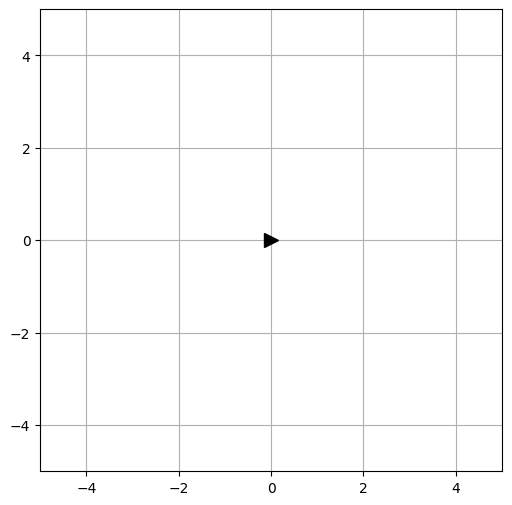

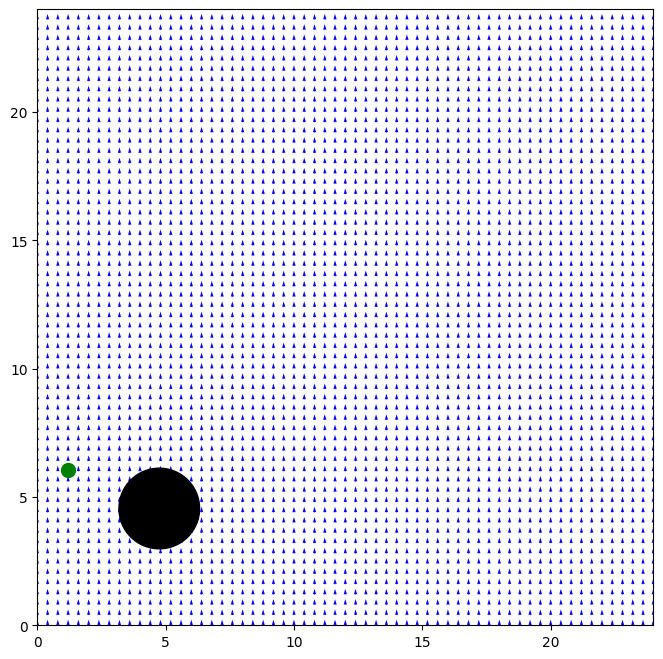

Posição do robô:  [1.2992150516038972, -1.520684588468145, 0.13869146179413933]
Laser pos ->  [1.2990226362187252, -1.5095262150928772, 0.2886911977196249]
Laser ori ->  [0.0018193857022977193, -4.726619731273202e-05, 1.587099150293393]


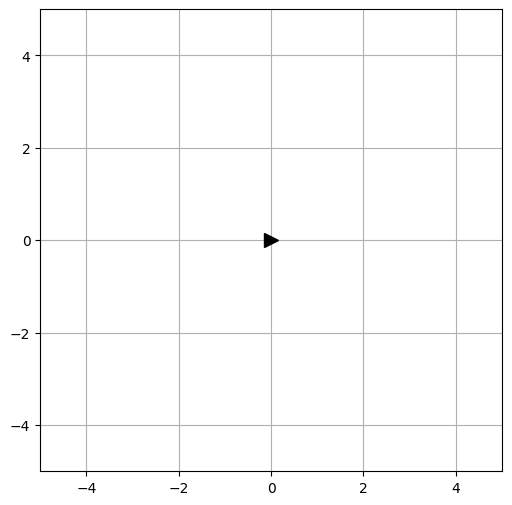

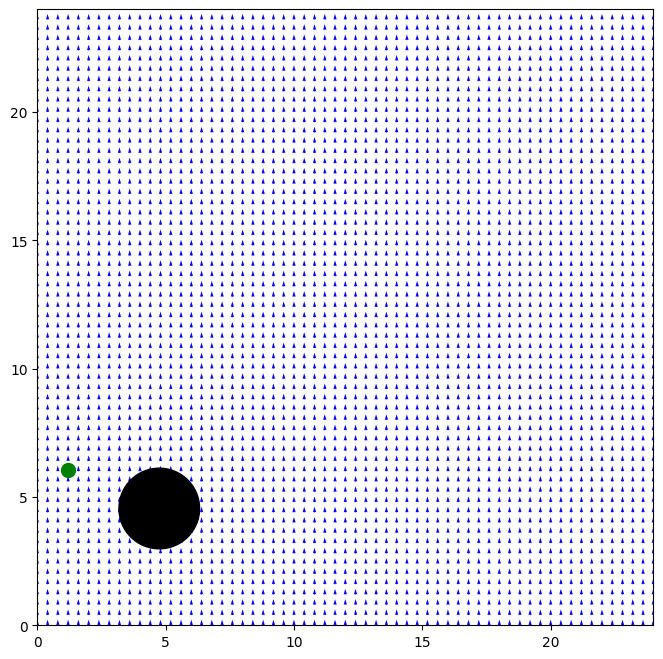

Posição do robô:  [1.2982304385963308, -1.4600851844648703, 0.13869142995839948]
Laser pos ->  [1.2980397544813855, -1.449029818605072, 0.28869116844076936]
Laser ori ->  [0.0018202866930452422, -4.60375101761643e-05, 1.5871040382742105]


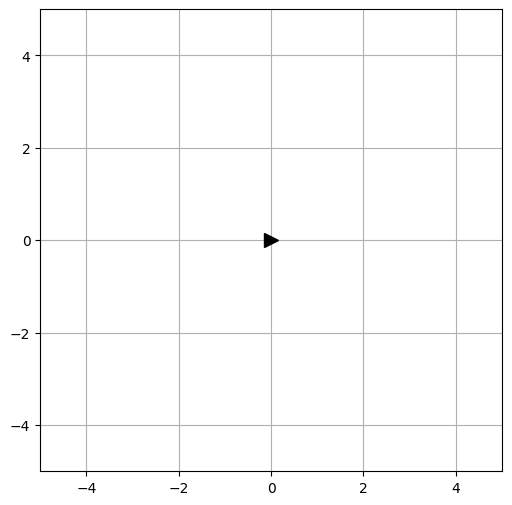

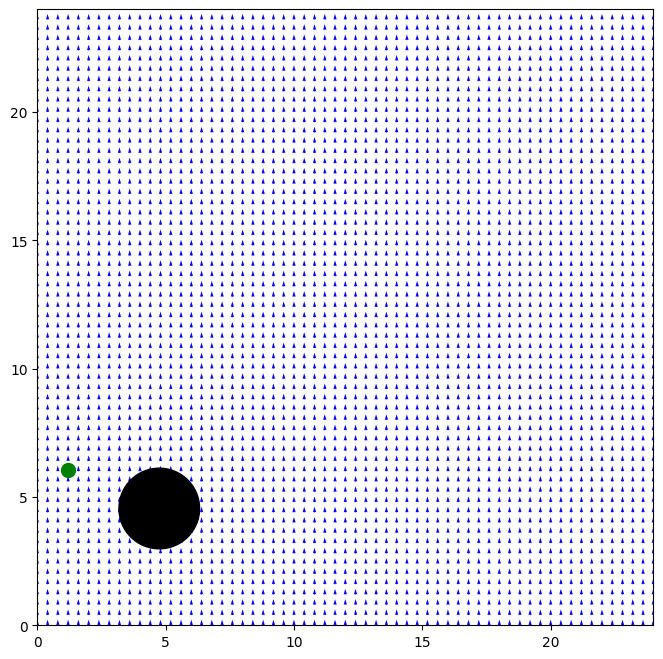

Posição do robô:  [1.2971922225474324, -1.3962074969397646, 0.13869148918126334]
Laser pos ->  [1.2970031686133552, -1.385243033361668, 0.2886912309281887]
Laser ori ->  [0.0018210175651031028, -4.584218949893416e-05, 1.5871085240303386]


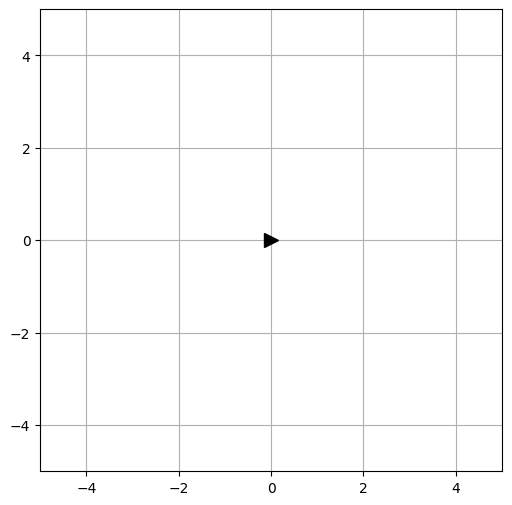

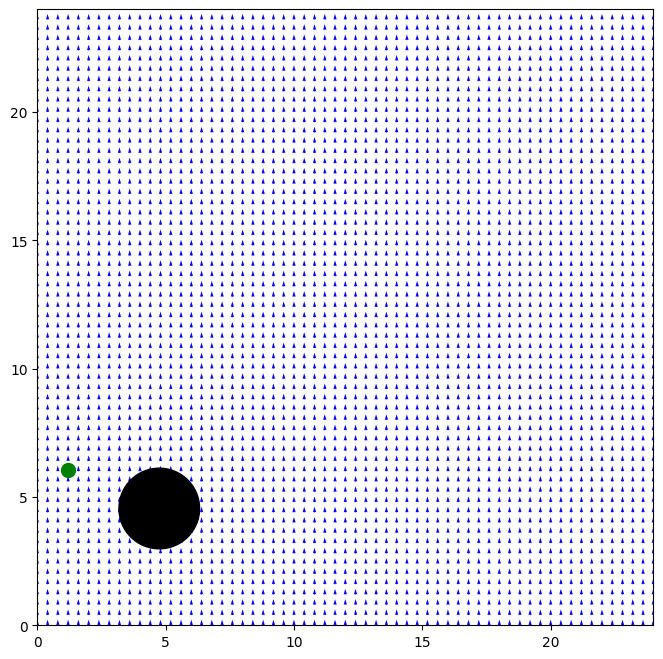

Posição do robô:  [1.2962228556927917, -1.3366115254889066, 0.138691525504379]
Laser pos ->  [1.295974543588408, -1.3220258407432581, 0.28869127249931004]
Laser ori ->  [0.0018203071508505165, -4.564327375700947e-05, 1.5871126737869712]


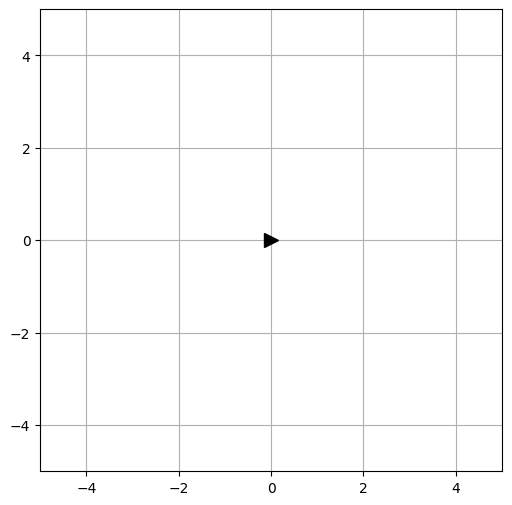

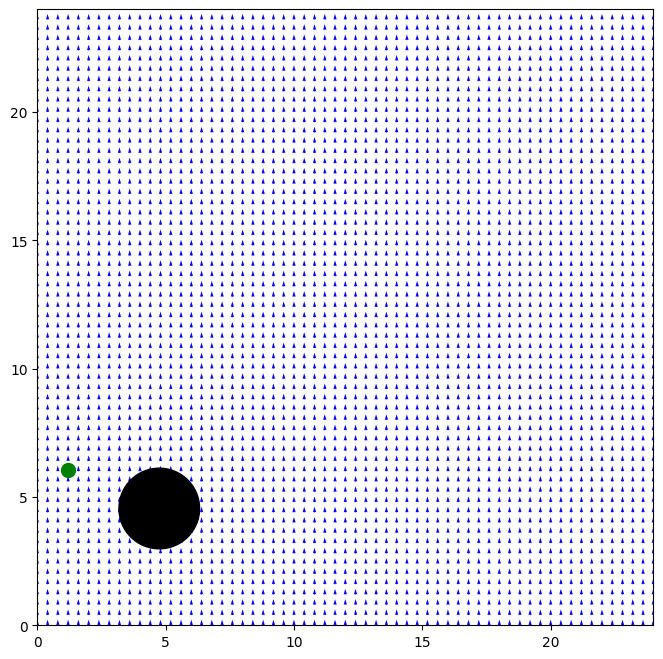

Posição do robô:  [1.2951998038368189, -1.2737827028335935, 0.1386915478189058]
Laser pos ->  [1.295013484370362, -1.2630028017450017, 0.28869129555840795]
Laser ori ->  [0.0018204095675249494, -4.552518913146996e-05, 1.5871183806314297]


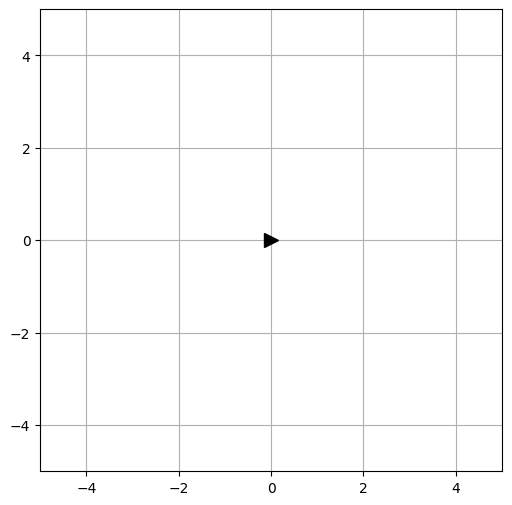

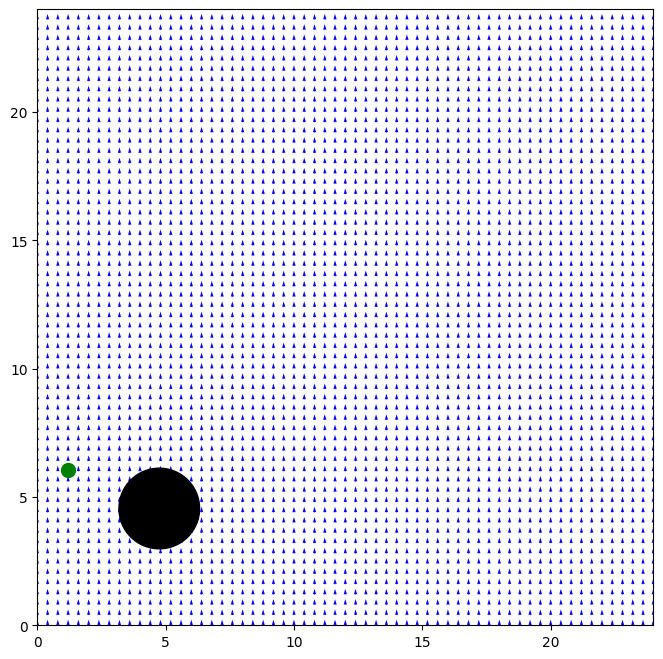

Posição do robô:  [1.294244530195262, -1.2151335356969333, 0.1386915744319549]
Laser pos ->  [1.294059669010601, -1.2044475580122256, 0.28869132185411883]
Laser ori ->  [0.0018205200102447917, -4.552377636495079e-05, 1.587122569448156]


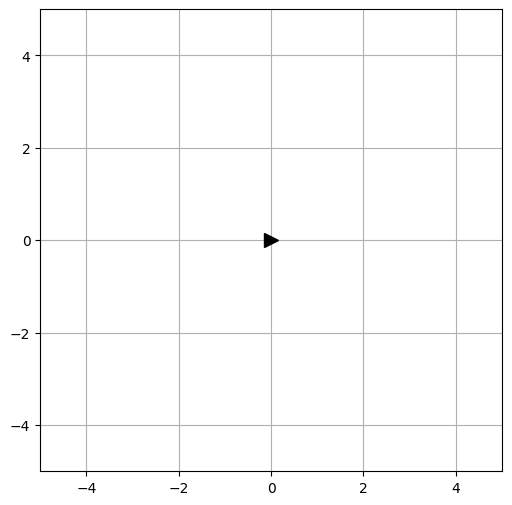

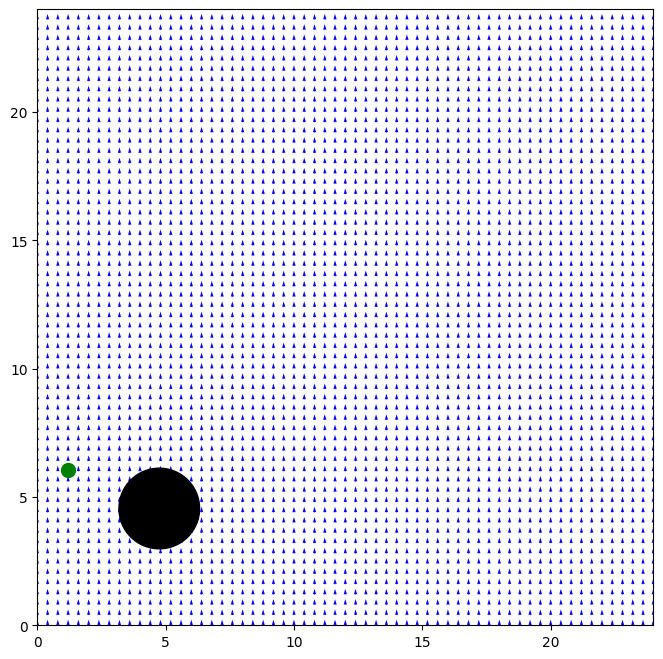

Posição do robô:  [1.2925281525785277, -1.1098454143625869, 0.13869160467228397]
Laser pos ->  [1.2924038289294264, -1.102873433171657, 0.28869134698301047]
Laser ori ->  [0.0018206091269478508, -4.572771136977634e-05, 1.587136104774002]


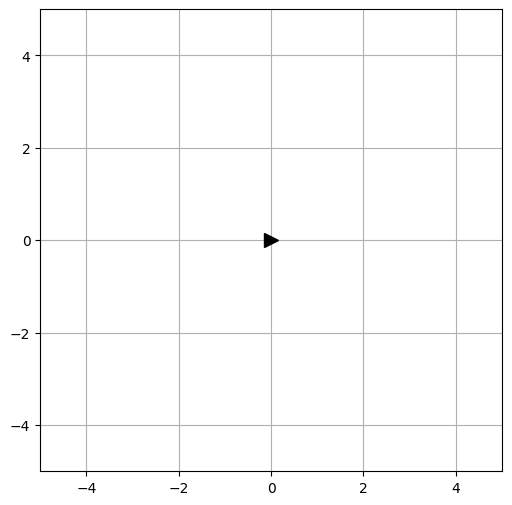

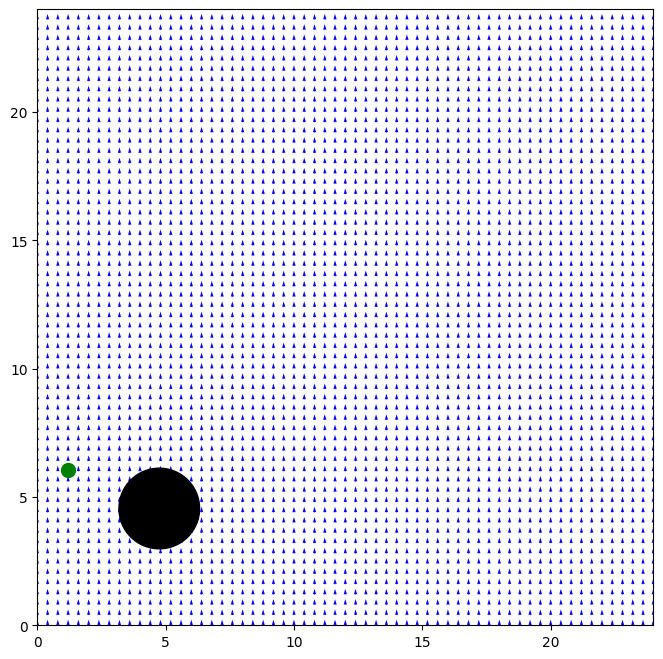

Posição do robô:  [1.291593711796747, -1.0524483325927922, 0.13869159080971422]
Laser pos ->  [1.2914128379418786, -1.0420072148458734, 0.2886913295795198]
Laser ori ->  [0.0018204966350077784, -4.59062714566117e-05, 1.5871358247780065]


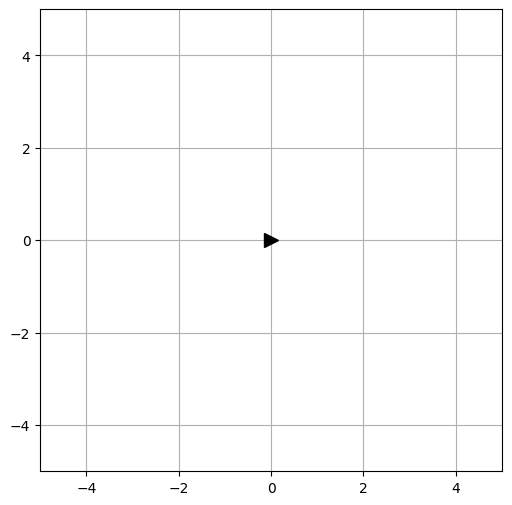

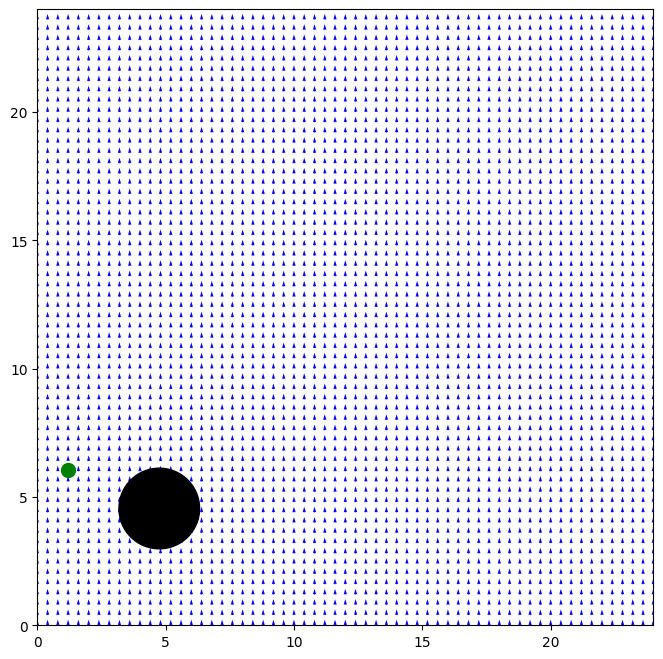

Posição do robô:  [1.2906099951347765, -0.9920302938474841, 0.1386915618548389]
Laser pos ->  [1.2904884294662997, -0.9852204033686642, 0.28869130001167187]
Laser ori ->  [0.001820302454427552, -4.599344738748698e-05, 1.5871437836701323]


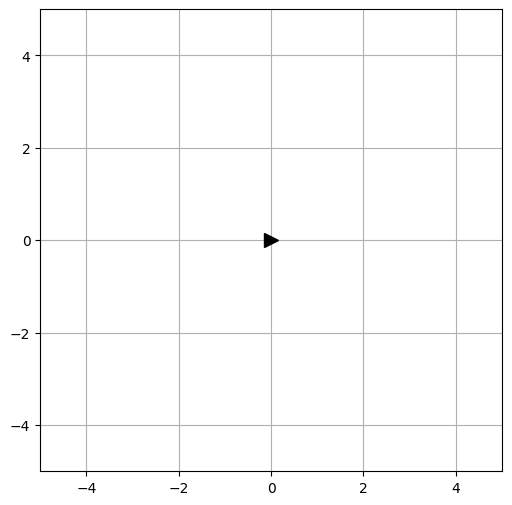

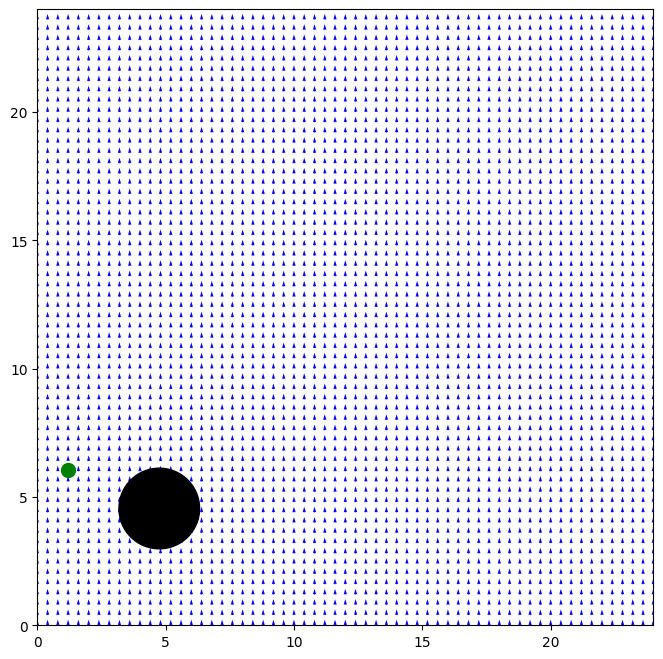

Posição do robô:  [1.2896926697531694, -0.9356616332269706, 0.13869152425568637]
Laser pos ->  [1.2894576302459688, -0.9218807919903106, 0.28869125767132986]
Laser ori ->  [0.0018200513553252445, -4.598946073174579e-05, 1.5871484074194582]


AxisError: axis 1 is out of bounds for array of dimension 1

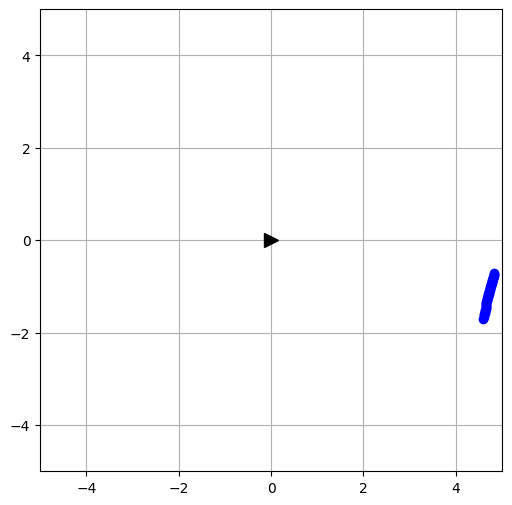

In [199]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()

if clientID != -1:
    print("Connected to remote API server")

    # Handle para o ROBÔ    
    laser_robot = sim.getObject('/Pioneer_p3dx')

    #Handle para o LASER
    laser = sim.getObject('/Pioneer_p3dx/fastHokuyo')

    # Handle para as juntas das RODAS
    motorLeft = sim.getObject('/Pioneer_p3dx_leftMotor')
    motorRight = sim.getObject('/Pioneer_p3dx_rightMotor')

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    # Handle utilizado como GOAL 
    goal = get_object_position(sim, '/tree')


    L = 0.381 # Distância entre as rodas
    r = 0.0975 # Raio da roda

    seguindo = False

    maxv = 1
    maxw = np.deg2rad(45)

    Ft_x = 0
    Ft_y = 0

    while True:

        laser_robot_position = get_object_position(sim, '/Pioneer_p3dx')
        print("Posição do robô: ", laser_robot_position)

        if laser_range_data is not None and laser_angle_data is not None:
            raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)

        # Ler os dados do sensor
        #raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        # Plotando os dados do sensor
        if laser_range_data is not None and laser_angle_data is not None:
            draw_laser_data(laser_data)

        laser_pos = get_object_position(sim, '/Pioneer_p3dx/fastHokuyo')
        laser_ori = get_object_orientation(sim, '/Pioneer_p3dx/fastHokuyo')
        print("Laser pos -> ", laser_pos)
        print("Laser ori -> ", laser_ori)

        # reshape laser_pos and laser_ori to 2 element array
        #laser_pos = np.array(laser_pos[:2])
        #laser_ori = np.array(laser_ori[2])

        Hlw = transformacao(laser_pos, laser_ori)


        v = 0.4
        w = 0

        # Calcular a força total
        Frep = [0, 0] # inicializando um vetor para percorrer
        # percorre o laser data
        for i in range(len(laser_data)):
            ang, dist = laser_data[i]
            # Se a leitura do laser for menor que a distância máxima do sensor
            if (5 - dist) > 0.1:
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                # Converter para o referencial global
                Aux = np.array(Hlw@[x, y, laser_pos[2], 1])
                obs = [Aux[0], Aux[1], 0.5]
                Aux3 = np.array(rep_force(np.array([laser_robot_position[0], laser_robot_position[1]]), obs))
            else:
                Aux3 = 0
            Frep = np.array(Frep) + np.array(Aux3) # Somatório das forças repulsivas lidar pelo sensor

        Fatt = att_force(np.array([laser_robot_position[0], laser_robot_position[1]]), np.array([goal[0], goal[1]]))
        Ft = Fatt + Frep

        Ft_x = Ft[0]
        Ft_y = Ft[1]

        if((Ft_x + Ft_y) == 0):
            Ft_x = +0.1
            Ft_y = +0.1

        v = (kv * ((Ft_x*(np.cos(laser_ori[2])) + Ft_y*(np.sin(laser_ori[2])))))
        w = (kw*((np.arctan2(Ft_y, Ft_x))-laser_ori[2]))
        w = (w + np.pi) % (2 * np.pi) - np.pi 

        # limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)

        # Constantes 
        kv = 1
        kw = 2

        # Calcular as velocidades das rodas
        vr = (2*v + L*w) / (2*r)
        vl = (2*v - L*w) / (2*r)

        # Setando as velocidades
        sim.setJointTargetVelocity(motorLeft, vl)
        sim.setJointTargetVelocity(motorRight, vr)

        # Checar se o robô chegou ao objetivo
        #if np.linalg.norm(laser_robot_position - goal) < 0.1:
        #    break

        # plotar a força total
        fig = plt.figure(figsize=(8, 8), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        ax.quiver(XX, YY, Ft_x, Ft_y, color='b')
        plt.plot(goal[0], goal[1], 'og', markersize=10)
        ax.add_patch(patches.Circle((obs[0], obs[1]), obs[4], color='k'))
        ax.set_xlim(0, WORLDX)
        ax.set_ylim(0, WORLDY)
        plt.show()


else:
    print("Failed to connect to remote API server")
    print("Exiting...")

print("Program ended")


print("Program ended")